In [1]:
import glob
import uproot
from dataclasses import dataclass

import numpy as np
import pandas as pd

import multiprocessing
from numba import njit
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
nTuple_dir_list = glob.glob("/root/data/qe-stkorn-v2/*/*.root")
print(nTuple_dir_list)
# debug
with uproot.open(nTuple_dir_list[0], mode="r") as file:
    print(file["reco;1"].keys(), end="\n\n")
    print(file["truth;1"].keys())

['/root/data/qe-stkorn-v2/user.stkorn.345324.PowhegPythia8EvtGen.DAOD_PHYS.e5769_s3681_r13145_p6490.121124-v2_output/user.stkorn.42053512._000001.output.root', '/root/data/qe-stkorn-v2/user.stkorn.345324.PowhegPythia8EvtGen.DAOD_PHYS.e5769_s3681_r13167_p6490.121124-v2_output/user.stkorn.42052934._000001.output.root', '/root/data/qe-stkorn-v2/user.stkorn.345324.PowhegPythia8EvtGen.DAOD_PHYS.e5769_s3681_r13144_p6490.121124-v2_output/user.stkorn.42053499._000001.output.root']
['actualInteractionsPerCrossing', 'averageInteractionsPerCrossing', 'weight_beamspot', 'eventNumber', 'mcChannelNumber', 'runNumber', 'trigPassed_HLT_e120_lhloose', 'trigPassed_HLT_e140_lhloose_nod0', 'trigPassed_HLT_e17_lhloose_mu14', 'trigPassed_HLT_e17_lhloose_nod0_mu14', 'trigPassed_HLT_e24_lhmedium_L1EM20VH', 'trigPassed_HLT_e26_lhtight_nod0_ivarloose', 'trigPassed_HLT_e60_lhmedium', 'trigPassed_HLT_e60_lhmedium_nod0', 'trigPassed_HLT_mu20_iloose_L1MU15', 'trigPassed_HLT_mu26_ivarmedium', 'trigPassed_HLT_mu40', 

In [3]:
def process_ntuple_files(nTuple_dir_list, branches, data_mode="truth"):
    accumulated_results = {branch: [] for branch in branches}

    for nTuple_file in nTuple_dir_list:
        with uproot.open(nTuple_file, mode="r") as file:
            data = file[data_mode + ";1"].arrays(branches, library="np")

        for branch in branches:
            accumulated_results[branch].append(data[branch])

    results = []
    for branch in tqdm(branches):
        concatenated = np.concatenate(accumulated_results[branch])
        results.append((branch, concatenated))
    return dict(results)

In [4]:

# Truth branches (mixing polarizing)

branches = [
    'HWW_MC_Hdecay1_decay1_afterFSR_pt',
    'HWW_MC_Hdecay1_decay1_afterFSR_eta',
    'HWW_MC_Hdecay1_decay1_afterFSR_phi',
    'HWW_MC_Hdecay1_decay1_afterFSR_pdgId',
    'HWW_MC_Hdecay1_decay2_afterFSR_pt',
    'HWW_MC_Hdecay1_decay2_afterFSR_eta',
    'HWW_MC_Hdecay1_decay2_afterFSR_phi',
    'HWW_MC_Hdecay1_decay2_afterFSR_pdgId',
    'HWW_MC_Hdecay2_decay1_afterFSR_pt',
    'HWW_MC_Hdecay2_decay1_afterFSR_eta',
    'HWW_MC_Hdecay2_decay1_afterFSR_phi',
    'HWW_MC_Hdecay2_decay1_afterFSR_pdgId',
    'HWW_MC_Hdecay2_decay2_afterFSR_pt',
    'HWW_MC_Hdecay2_decay2_afterFSR_eta',
    'HWW_MC_Hdecay2_decay2_afterFSR_phi',
    'HWW_MC_Hdecay2_decay2_afterFSR_pdgId',
    'HWW_MC_Hdecay1_afterFSR_pt',
    'HWW_MC_Hdecay1_afterFSR_eta',
    'HWW_MC_Hdecay1_afterFSR_phi',
    'HWW_MC_Hdecay1_afterFSR_m',
    'HWW_MC_Hdecay1_afterFSR_pdgId',
    'HWW_MC_Hdecay2_afterFSR_pt',
    'HWW_MC_Hdecay2_afterFSR_eta',
    'HWW_MC_Hdecay2_afterFSR_phi',
    'HWW_MC_Hdecay2_afterFSR_m',
    'HWW_MC_Hdecay2_afterFSR_pdgId',
    'HWW_MC_H_afterFSR_pt',
    'HWW_MC_H_afterFSR_eta',
    'HWW_MC_H_afterFSR_phi',
    'HWW_MC_H_afterFSR_m',
    'HWW_MC_H_afterFSR_pdgId',
    'eventNumber',
]

truth_mixing_data = process_ntuple_files(nTuple_dir_list, branches)

# Extract variables from accumulated results
(
    truth_lnu11_pt, truth_lnu11_eta, truth_lnu11_phi, truth_lnu11_id,
    truth_lnu12_pt, truth_lnu12_eta, truth_lnu12_phi, truth_lnu12_id,
    truth_lnu21_pt, truth_lnu21_eta, truth_lnu21_phi, truth_lnu21_id,
    truth_lnu22_pt, truth_lnu22_eta, truth_lnu22_phi, truth_lnu22_id,
    truth_w1_pt, truth_w1_eta, truth_w1_phi, truth_w1_m, truth_w1_id,
    truth_w2_pt, truth_w2_eta, truth_w2_phi, truth_w2_m, truth_w2_id,
    truth_higgs_pt, truth_higgs_eta, truth_higgs_phi, truth_higgs_m, truth_higgs_id,
    truth_eventNumber,
) = [truth_mixing_data[branch] for branch in branches]
print('Truth sample length:', len(truth_higgs_pt))

100%|██████████| 32/32 [00:00<00:00, 298.24it/s]

Truth sample length: 7311000


In [5]:
# truth branches (only longitudinal polarzing) --> leptons are  modified by CAR alg

branches = [
    'MC_Hdecay1_decay1_afterFSR_CAR_pt',
    'MC_Hdecay1_decay1_afterFSR_CAR_eta',
    'MC_Hdecay1_decay1_afterFSR_CAR_phi',
    'MC_Hdecay1_decay1_afterFSR_CAR_pdgId',
    'MC_Hdecay1_decay2_afterFSR_CAR_pt',
    'MC_Hdecay1_decay2_afterFSR_CAR_eta',
    'MC_Hdecay1_decay2_afterFSR_CAR_phi',
    'MC_Hdecay1_decay2_afterFSR_CAR_pdgId',
    'MC_Hdecay2_decay1_afterFSR_CAR_pt',
    'MC_Hdecay2_decay1_afterFSR_CAR_eta',
    'MC_Hdecay2_decay1_afterFSR_CAR_phi',
    'MC_Hdecay2_decay1_afterFSR_CAR_pdgId',
    'MC_Hdecay2_decay2_afterFSR_CAR_pt',
    'MC_Hdecay2_decay2_afterFSR_CAR_eta',
    'MC_Hdecay2_decay2_afterFSR_CAR_phi',
    'MC_Hdecay2_decay2_afterFSR_CAR_pdgId',
]

truth_only_data = process_ntuple_files(nTuple_dir_list, branches)

(
    truth_lnu11_car_pt, truth_lnu11_car_eta, truth_lnu11_car_phi, truth_lnu11_car_id,
    truth_lnu12_car_pt, truth_lnu12_car_eta, truth_lnu12_car_phi, truth_lnu12_car_id,
    truth_lnu21_car_pt, truth_lnu21_car_eta, truth_lnu21_car_phi, truth_lnu21_car_id,
    truth_lnu22_car_pt, truth_lnu22_car_eta, truth_lnu22_car_phi, truth_lnu22_car_id,
) = [truth_only_data[branch] for branch in branches]
print('Truth CAR sample length:', len(truth_lnu11_car_pt))

100%|██████████| 16/16 [00:00<00:00, 268.55it/s]

Truth CAR sample length: 7311000


3282435
7311000


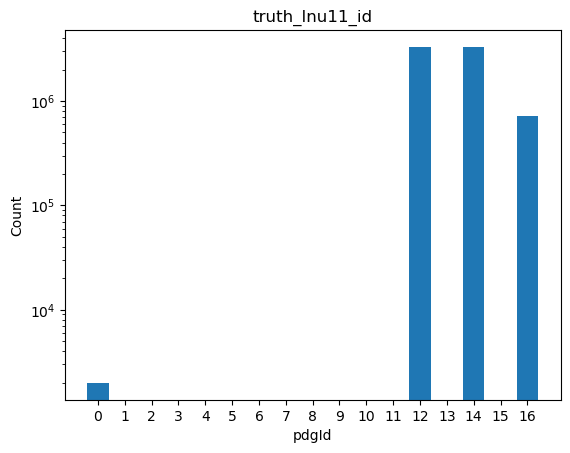

3282435
7311000


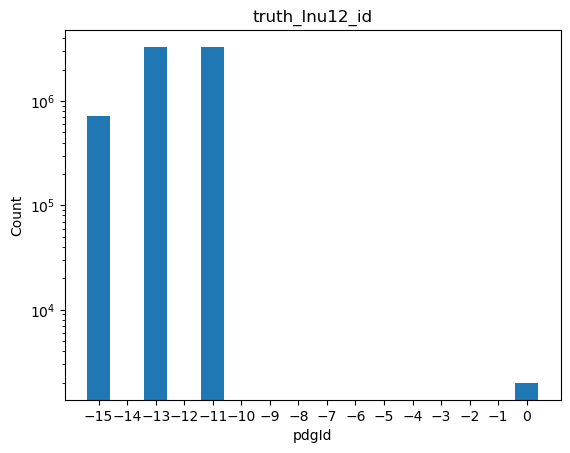

3302340
7311000


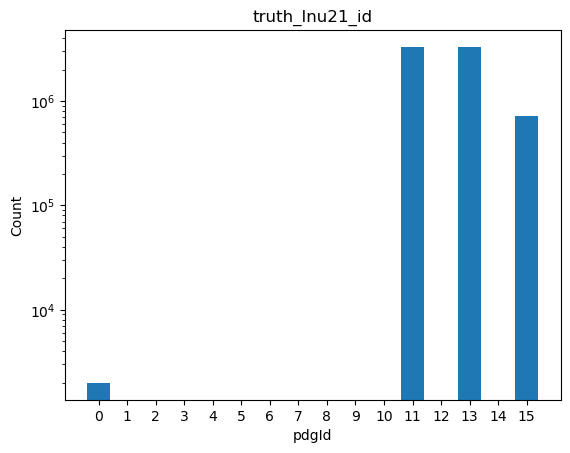

3302340
7311000


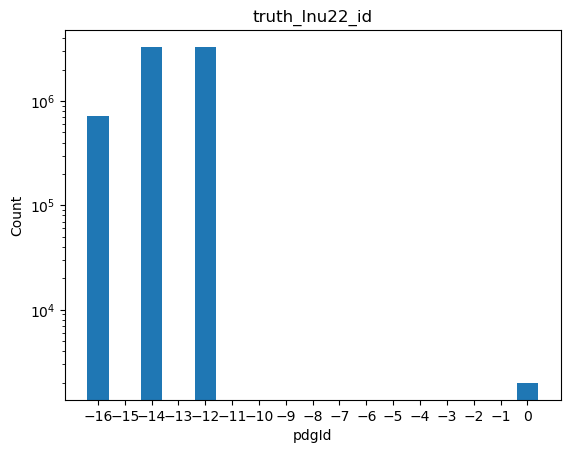

7309015
7311000


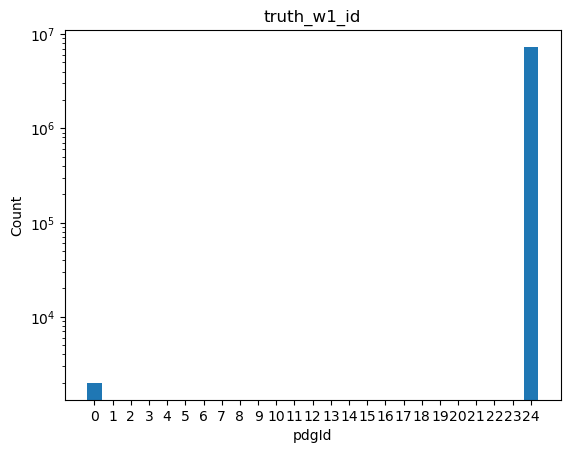

7309015
7311000


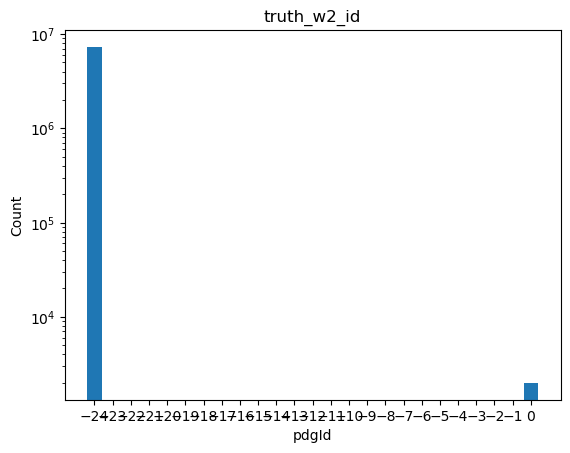

7311000
7311000


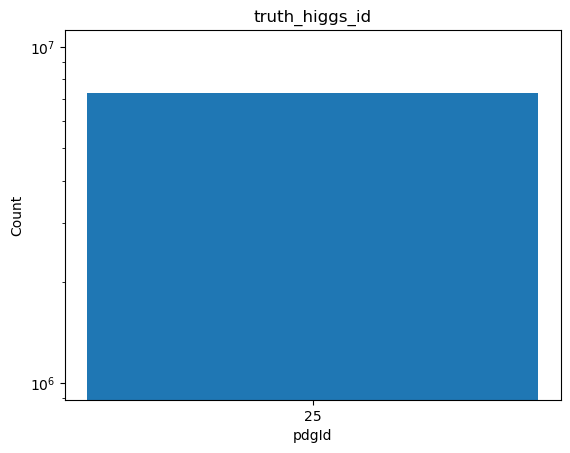

In [6]:
print(np.sum(truth_lnu11_id==12))
print(len(truth_lnu11_id))
unique_ids, counts = np.unique(truth_lnu11_id, return_counts=True)
plt.bar(unique_ids, counts)
plt.semilogy()
plt.xticks(np.arange(unique_ids.min(), unique_ids.max() + 1, 1))
plt.xlabel("pdgId")
plt.ylabel("Count")
plt.title("truth_lnu11_id")
plt.show()

print(np.sum(truth_lnu12_id==-11))
print(len(truth_lnu12_id))
unique_ids, counts = np.unique(truth_lnu12_id, return_counts=True)
plt.bar(unique_ids, counts)
plt.semilogy()
plt.xticks(np.arange(unique_ids.min(), unique_ids.max() + 1, 1))
plt.xlabel("pdgId")
plt.ylabel("Count")
plt.title("truth_lnu12_id")
plt.show()

print(np.sum(truth_lnu21_id==13))
print(len(truth_lnu21_id))
unique_ids, counts = np.unique(truth_lnu21_id, return_counts=True)
plt.bar(unique_ids, counts)
plt.semilogy()
plt.xticks(np.arange(unique_ids.min(), unique_ids.max() + 1, 1))
plt.xlabel("pdgId")
plt.ylabel("Count")
plt.title("truth_lnu21_id")
plt.show()

print(np.sum(truth_lnu22_id==-14))
print(len(truth_lnu22_id))
unique_ids, counts = np.unique(truth_lnu22_id, return_counts=True)
plt.bar(unique_ids, counts)
plt.semilogy()
plt.xticks(np.arange(unique_ids.min(), unique_ids.max() + 1, 1))
plt.xlabel("pdgId")
plt.ylabel("Count")
plt.title("truth_lnu22_id")
plt.show()

print(np.sum(truth_w1_id==24))
print(len(truth_w1_id))
unique_ids, counts = np.unique(truth_w1_id, return_counts=True)
plt.bar(unique_ids, counts)
plt.semilogy()
plt.xticks(np.arange(unique_ids.min(), unique_ids.max() + 1, 1))
plt.xlabel("pdgId")
plt.ylabel("Count")
plt.title("truth_w1_id")
plt.show()

print(np.sum(truth_w2_id==-24))
print(len(truth_w2_id))
unique_ids, counts = np.unique(truth_w2_id, return_counts=True)
plt.bar(unique_ids, counts)
plt.semilogy()
plt.xticks(np.arange(unique_ids.min(), unique_ids.max() + 1, 1))
plt.xlabel("pdgId")
plt.ylabel("Count")
plt.title("truth_w2_id")
plt.show()

print(np.sum(truth_higgs_id==25))
print(len(truth_higgs_id))
unique_ids, counts = np.unique(truth_higgs_id, return_counts=True)
plt.bar(unique_ids, counts)
plt.semilogy()
plt.xticks(np.arange(unique_ids.min(), unique_ids.max() + 1, 1))
plt.xlabel("pdgId")
plt.ylabel("Count")
plt.title("truth_higgs_id")
plt.show()

In [7]:
print(truth_lnu11_id[:20])
print(-1*truth_lnu12_id[:20])

[12 12 14 16 14 14 14 12 12 16 12 16 14 12 14 16 16 14 12 14]
[11 11 13 15 13 13 13 11 11 15 11 15 13 11 13 15 15 13 11 13]


In [8]:
test1 = 1*(truth_lnu11_id * truth_lnu12_id == -11*12).sum()
test2 = 1*(truth_lnu11_id * truth_lnu12_id == -13*14).sum()
print(test1 + test2)
print(1*((truth_lnu11_id * truth_lnu12_id == -11*12) | (truth_lnu11_id * truth_lnu12_id == -13*14)).sum())
np.unique(truth_lnu11_id * truth_lnu12_id, return_counts=True)

6587332
6587332


(array([-240, -182, -132,    0], dtype=int32),
 array([ 721683, 3304897, 3282435,    1985]))

In [9]:
test1 = 1*(truth_lnu21_id * truth_lnu22_id == -11*12).sum()
test2 = 1*(truth_lnu21_id * truth_lnu22_id == -13*14).sum()
print(test1 + test2)
print(1*((truth_lnu21_id * truth_lnu22_id == -11*12) | (truth_lnu21_id * truth_lnu22_id == -13*14)).sum())
np.unique(truth_lnu21_id * truth_lnu22_id, return_counts=True)

6587342
6587342


(array([-240, -182, -132,    0], dtype=int32),
 array([ 721673, 3302340, 3285002,    1985]))

In [10]:
def is_valid(part1, part2, part11, part12, part21, part22):
    '''
    :params part1 : pdgId of the Hdecay1 --> W+
    :params part2 : pdgId of the Hdecay2 --> W-
    :params part11: pdgId of the particle 1 from Hdecay1 --> neutrino
    :params part12: pdgId of the particle 2 from Hdecay1 --> lepton
    :params part21: pdgId of the particle 1 from Hdecay2 --> lepton
    :params part22: pdgId of the particle 2 from Hdecay2 --> neutrino
    
    :return: boolean array of valid H->WW*->lvlv events
    '''
    print("Initial:", len(part1))
    cond1 = (part11 * part12 == -11*12) | (part11 * part12 == -13*14)  # pairing correct l and nu for part1
    print("Remain :", cond1.sum())
    cond2 = (part21 * part22 == -11*12) | (part21 * part22 == -13*14)  # pairing correct l and nu for part2
    print("Remain :", cond2.sum())
    cond3 = part12 * part21 == -11*13  # pairing diff flav leps and conserving charge (e, mu only)
    print("Remain :", cond3.sum())
    cond4 = part1 == 24   # confirm W+ boson (excluding zero paddings)
    print("Remain :", cond4.sum())
    cond5 = part2 == -24  # confirm W- boson (excluding zero paddings)
    print("Remain :", cond5.sum())
    # higgs has already been checked to be the correct particle ID form previous plots
    print("")
    return cond1 & cond2 & cond3 & cond4 & cond5

valid_ind = is_valid(truth_w1_id, truth_w2_id, truth_lnu11_id, truth_lnu12_id, truth_lnu21_id, truth_lnu22_id)
valid_car_ind = is_valid(truth_w1_id, truth_w2_id, truth_lnu11_car_id, truth_lnu12_car_id, truth_lnu21_car_id, truth_lnu22_car_id)
print(1*(valid_ind).sum())
print("Check CAR results:", np.all(valid_ind == valid_car_ind))

print("Double check the valid indices...", "before", len(truth_w1_id), "after", len(truth_w1_id[valid_ind]))
print("Ratio of double checking:", len(truth_w1_id[valid_ind]) / len(truth_w1_id))

Initial: 7311000
Remain : 6587332


Remain : 6587342
Remain : 2963488
Remain : 7309015
Remain : 7309015

Initial: 7311000
Remain : 6587332
Remain : 6587342
Remain : 2963488
Remain : 7309015
Remain : 7309015

2963488
Check CAR results: True
Double check the valid indices... before 7311000 after 2963488
Ratio of double checking: 0.40534646423197923


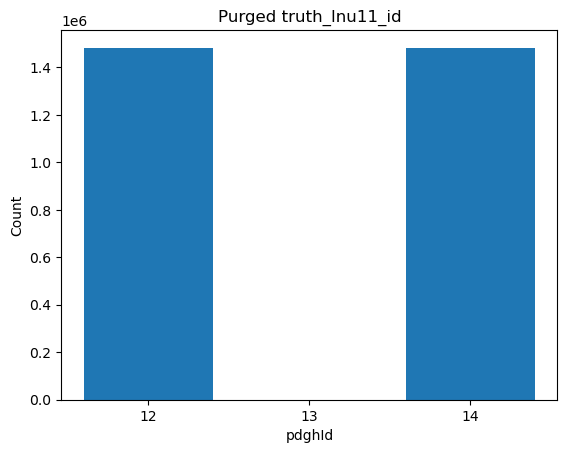

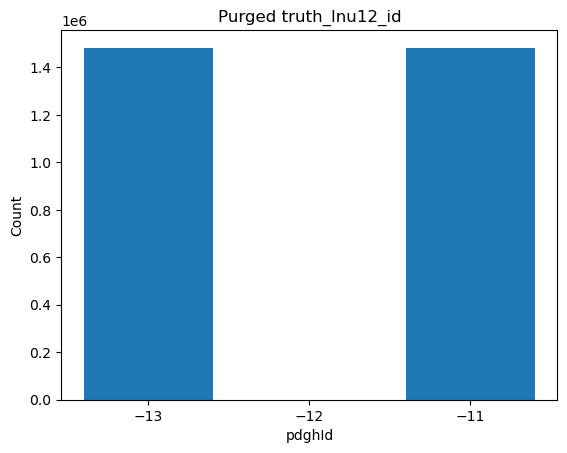

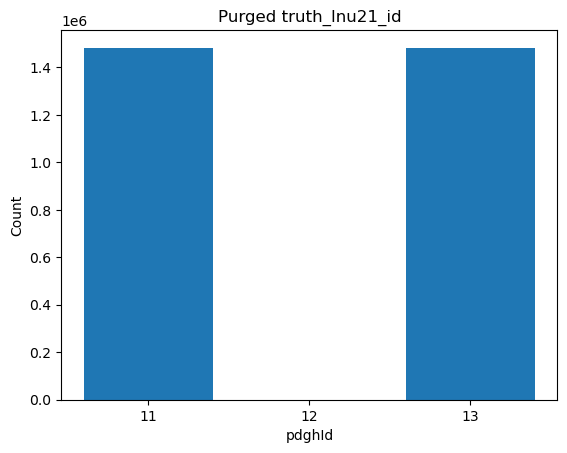

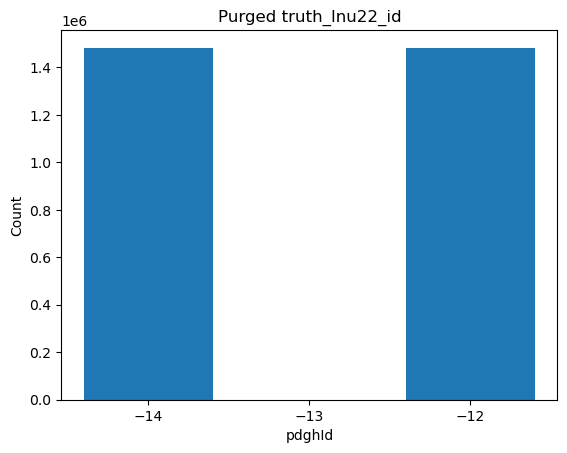

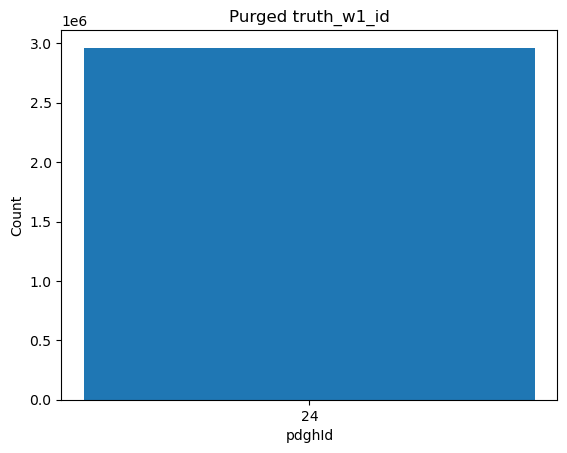

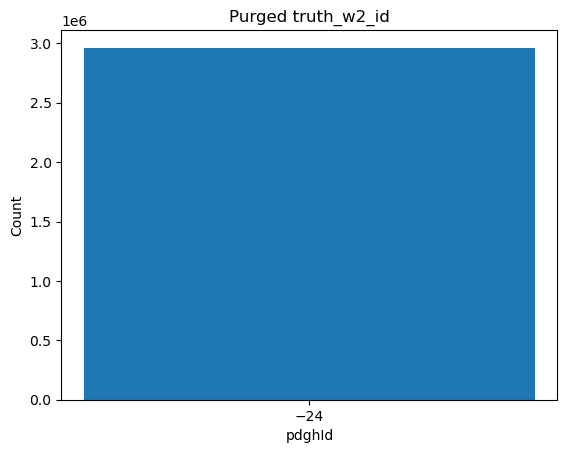

Two w boson need to have same length... (before double checking) True
Two w boson need to have same length... True


In [11]:
unique_ids, counts = np.unique(truth_lnu11_id[valid_ind], return_counts=True)
plt.bar(unique_ids, counts)
# plt.semilogy()
plt.xticks(np.arange(unique_ids.min(), unique_ids.max() + 1, 1))
plt.xlabel("pdghId")
plt.ylabel("Count")
plt.title("Purged truth_lnu11_id")
plt.show()

unique_ids, counts = np.unique(truth_lnu12_id[valid_ind], return_counts=True)
plt.bar(unique_ids, counts)
# plt.semilogy()
plt.xticks(np.arange(unique_ids.min(), unique_ids.max() + 1, 1))
plt.xlabel("pdghId")
plt.ylabel("Count")
plt.title("Purged truth_lnu12_id")
plt.show()

unique_ids, counts = np.unique(truth_lnu21_id[valid_ind], return_counts=True)
plt.bar(unique_ids, counts)
# plt.semilogy()
plt.xticks(np.arange(unique_ids.min(), unique_ids.max() + 1, 1))
plt.xlabel("pdghId")
plt.ylabel("Count")
plt.title("Purged truth_lnu21_id")
plt.show()

unique_ids, counts = np.unique(truth_lnu22_id[valid_ind], return_counts=True)
plt.bar(unique_ids, counts)
# plt.semilogy()
plt.xticks(np.arange(unique_ids.min(), unique_ids.max() + 1, 1))
plt.xlabel("pdghId")
plt.ylabel("Count")
plt.title("Purged truth_lnu22_id")
plt.show()

unique_ids, counts = np.unique(truth_w1_id[valid_ind], return_counts=True)
plt.bar(unique_ids, counts)
# plt.semilogy()
plt.xticks(np.arange(unique_ids.min(), unique_ids.max() + 1, 1))
plt.xlabel("pdghId")
plt.ylabel("Count")
plt.title("Purged truth_w1_id")
plt.show()

unique_ids, counts = np.unique(truth_w2_id[valid_ind], return_counts=True)
plt.bar(unique_ids, counts)
# plt.semilogy()
plt.xticks(np.arange(unique_ids.min(), unique_ids.max() + 1, 1))
plt.xlabel("pdghId")
plt.ylabel("Count")
plt.title("Purged truth_w2_id")
plt.show()

print(
    "Two w boson need to have same length... (before double checking)",
    np.all(len(truth_w1_id == len(truth_w2_id))),
)
print(
    "Two w boson need to have same length...",
    np.all(len(truth_w1_id[valid_ind] == len(truth_w2_id[valid_ind]))),
)

In [12]:
def test_plot(data, title, xlabel="[MeV]", ylabel="Count"):
    plt.figure(figsize=(12, 6))
    plt.hist(data, bins=np.linspace(data.min(), data.max(), 101))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
    plt.close()

In [13]:
def px(pt, phi):
    return pt * np.cos(phi)

def py(pt, phi):
    return pt * np.sin(phi)

def pz(pt, eta):
    return pt * np.sinh(eta)

def energy(pt, eta, m):
    return np.sqrt(np.square(pt) + np.square(pz(pt, eta)) + np.square(m))

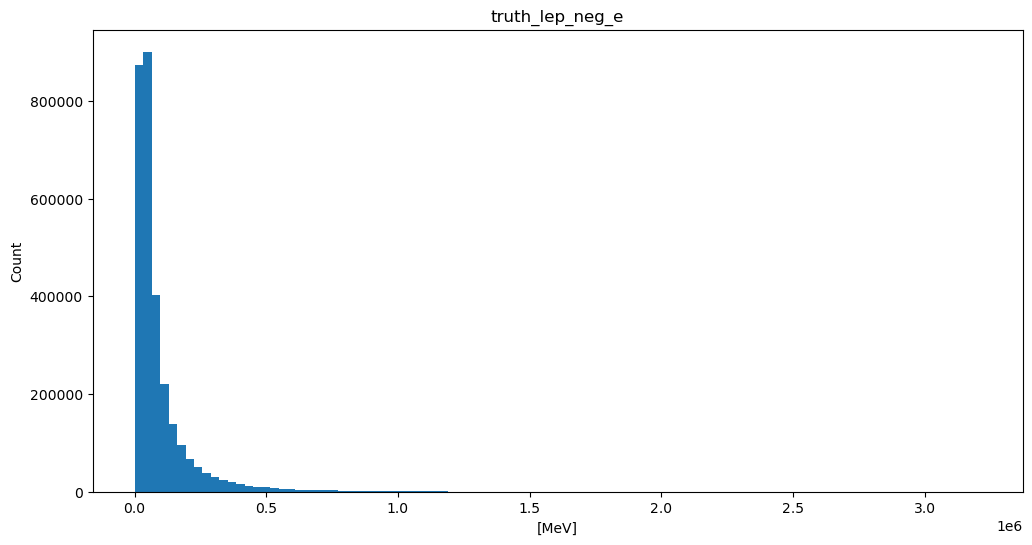

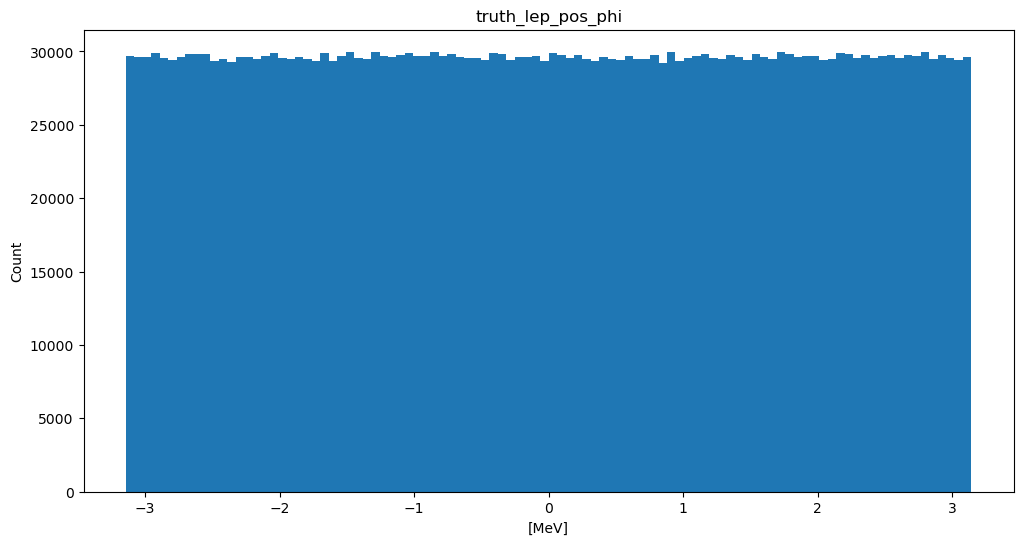

In [14]:
# truth lep

truth_nu_pos_pt = truth_lnu11_pt[valid_ind]
truth_lep_neg_pt = truth_lnu12_pt[valid_ind]
truth_lep_pos_pt = truth_lnu21_pt[valid_ind]
truth_nu_neg_pt = truth_lnu22_pt[valid_ind]
# test_plot(truth_nu_pos_pt, 'truth_nu_pos_pt')
# test_plot(truth_lep_neg_pt, 'truth_lep_neg_pt')

truth_nu_pos_eta = truth_lnu11_eta[valid_ind]
truth_lep_neg_eta = truth_lnu12_eta[valid_ind]
truth_lep_pos_eta = truth_lnu21_eta[valid_ind]
truth_nu_neg_eta = truth_lnu22_eta[valid_ind]

truth_nu_pos_phi = truth_lnu11_phi[valid_ind]
truth_lep_neg_phi = truth_lnu12_phi[valid_ind]
truth_lep_pos_phi = truth_lnu21_phi[valid_ind]
truth_nu_neg_phi = truth_lnu22_phi[valid_ind]

truth_nu_pos_m = np.zeros(truth_nu_pos_phi.shape)
lep_neg_m = np.full(len(truth_nu_pos_m), -999, dtype=np.float32)
mask_electron = truth_lnu12_id[valid_ind] == -11
mask_muon = truth_lnu12_id[valid_ind] == -13
lep_neg_m[mask_electron] = 0.000511
lep_neg_m[mask_muon] = 0.105658
if not np.all(mask_muon | mask_electron):
    print("Error: lep_neg_id is not lepton")
lep_pos_m = np.full(len(truth_nu_pos_phi), -999, dtype=np.float32)
mask_electron = truth_lnu21_id[valid_ind] == 11
mask_muon = truth_lnu21_id[valid_ind] == 13
lep_pos_m[mask_electron] = 0.000511
lep_pos_m[mask_muon] = 0.105658
if not np.all(mask_muon | mask_electron):
    print("Error: lep_pos_id is not lepton")
truth_nu_neg_m = np.zeros(truth_nu_neg_phi.shape)

truth_nu_pos_px = px(truth_nu_pos_pt, truth_nu_pos_phi)
truth_nu_pos_py = py(truth_nu_pos_pt, truth_nu_pos_phi)
truth_nu_pos_pz = pz(truth_nu_pos_pt, truth_nu_pos_eta)
truth_nu_pos_e = energy(truth_nu_pos_pt, truth_nu_pos_eta, truth_nu_pos_m)
truth_nu_neg_px = px(truth_nu_neg_pt, truth_nu_neg_phi)
truth_nu_neg_py = py(truth_nu_neg_pt, truth_nu_neg_phi)
truth_nu_neg_pz = pz(truth_nu_neg_pt, truth_nu_neg_eta)
truth_nu_neg_e = energy(truth_nu_neg_pt, truth_nu_neg_eta, truth_nu_neg_m)
truth_lep_pos_px = px(truth_lep_pos_pt, truth_lep_pos_phi)
truth_lep_pos_py = py(truth_lep_pos_pt, truth_lep_pos_phi)
truth_lep_pos_pz = pz(truth_lep_pos_pt, truth_lep_pos_eta)
truth_lep_pos_e = energy(truth_lep_pos_pt, truth_lep_pos_eta, lep_pos_m)
truth_lep_neg_px = px(truth_lep_neg_pt, truth_lep_neg_phi)
truth_lep_neg_py = py(truth_lep_neg_pt, truth_lep_neg_phi)
truth_lep_neg_pz = pz(truth_lep_neg_pt, truth_lep_neg_eta)
truth_lep_neg_e = energy(truth_lep_neg_pt, truth_lep_neg_eta, lep_neg_m)
test_plot(truth_lep_neg_e, "truth_lep_neg_e")
test_plot(truth_lep_pos_phi, "truth_lep_pos_phi")

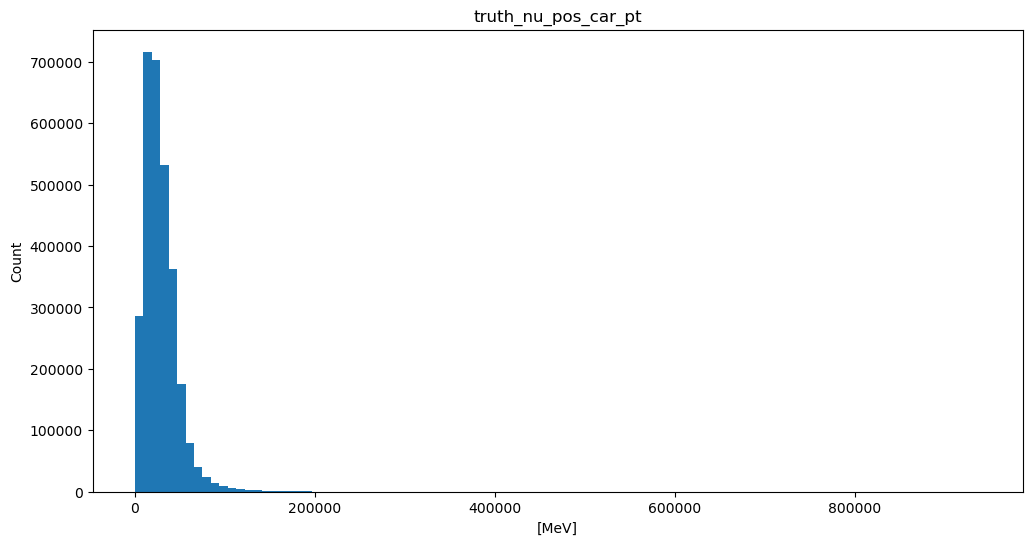

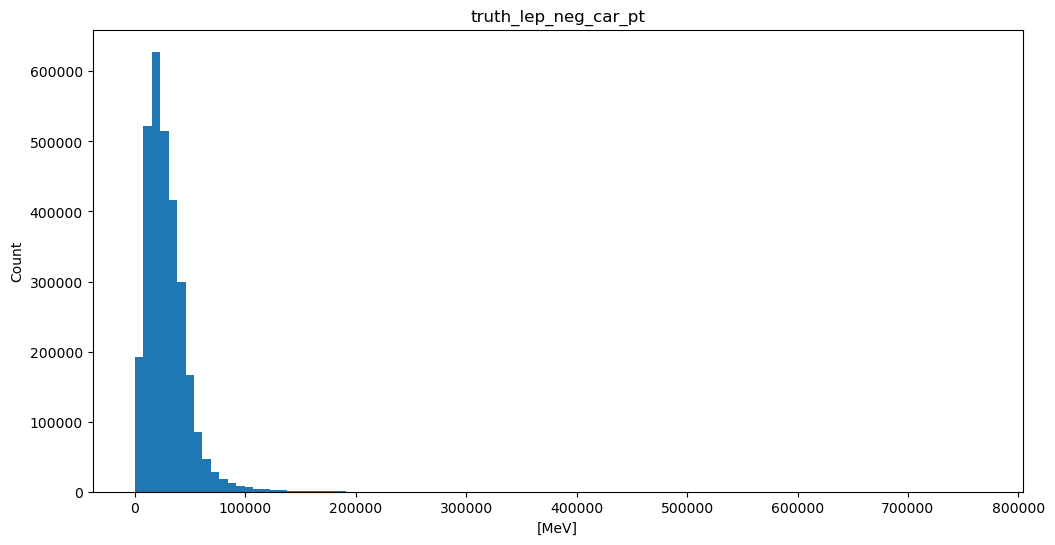

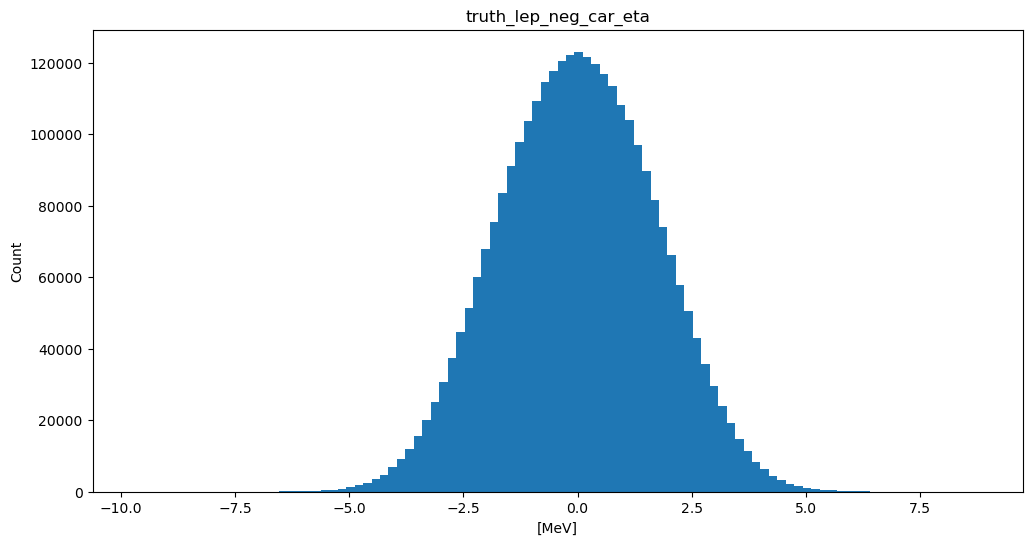

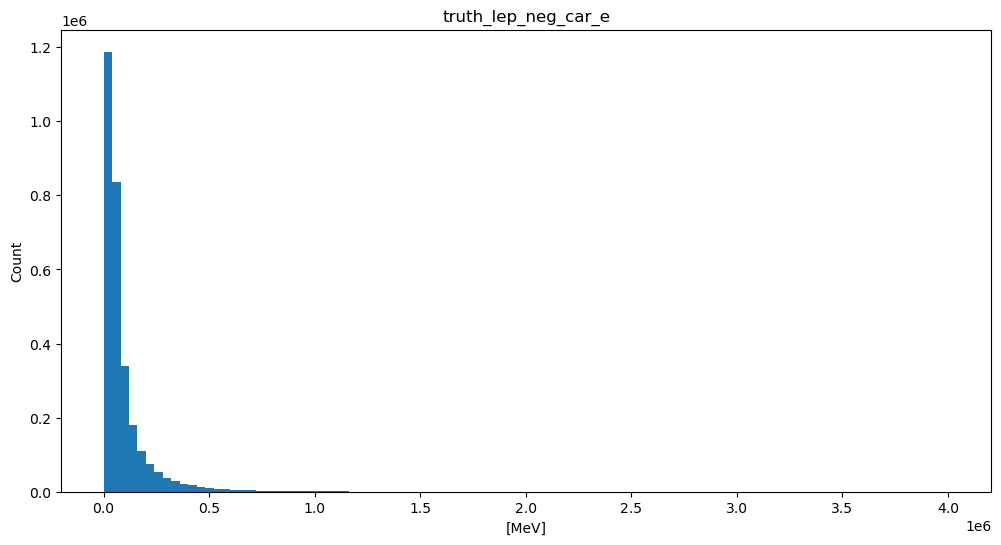

In [15]:
# truth lep (CAR)

truth_nu_pos_car_pt = truth_lnu11_car_pt[valid_ind]
truth_lep_neg_car_pt = truth_lnu12_car_pt[valid_ind]
truth_lep_pos_car_pt = truth_lnu21_car_pt[valid_ind]
truth_nu_neg_car_pt = truth_lnu22_car_pt[valid_ind]
test_plot(truth_nu_pos_car_pt, "truth_nu_pos_car_pt")
test_plot(truth_lep_neg_car_pt, "truth_lep_neg_car_pt")

truth_nu_pos_car_eta = truth_lnu11_car_eta[valid_ind]
truth_lep_neg_car_eta = truth_lnu12_car_eta[valid_ind]
truth_lep_pos_car_eta = truth_lnu21_car_eta[valid_ind]
truth_nu_neg_car_eta = truth_lnu22_car_eta[valid_ind]
test_plot(truth_lep_neg_car_eta, "truth_lep_neg_car_eta")


truth_nu_pos_car_phi = truth_lnu11_car_phi[valid_ind]
truth_lep_neg_car_phi = truth_lnu12_car_phi[valid_ind]
truth_lep_pos_car_phi = truth_lnu21_car_phi[valid_ind]
truth_nu_neg_car_phi = truth_lnu22_car_phi[valid_ind]

truth_nu_pos_car_m = np.zeros(truth_nu_pos_car_phi.shape)
lep_neg_car_m = np.full(len(truth_nu_pos_car_phi), -999, dtype=np.float32)
mask_electron = truth_lnu12_car_id[valid_ind] == -11
mask_muon = truth_lnu12_car_id[valid_ind] == -13
lep_neg_car_m[mask_electron] = 0.000511
lep_neg_car_m[mask_muon] = 0.105658
if not np.all(mask_muon | mask_electron):
    print("Error: lep_neg_id is not lepton")
lep_pos_car_m = np.full(len(truth_nu_pos_car_phi), -999, dtype=np.float32)
mask_electron = truth_lnu21_car_id[valid_ind] == 11
mask_muon = truth_lnu21_car_id[valid_ind] == 13
lep_pos_car_m[mask_electron] = 0.000511
lep_pos_car_m[mask_muon] = 0.105658
if not np.all(mask_muon | mask_electron):
    print("Error: lep_pos_id is not lepton")
truth_nu_neg_car_m = np.zeros(truth_nu_neg_car_phi.shape)

truth_nu_pos_car_px = px(truth_nu_pos_car_pt, truth_nu_pos_car_phi)
truth_nu_pos_car_py = py(truth_nu_pos_car_pt, truth_nu_pos_car_phi)
truth_nu_pos_car_pz = pz(truth_nu_pos_car_pt, truth_nu_pos_car_eta)
truth_nu_pos_car_e = energy(
    truth_nu_pos_car_pt, truth_nu_pos_car_eta, truth_nu_pos_car_m
)
truth_nu_neg_car_px = px(truth_nu_neg_car_pt, truth_nu_neg_car_phi)
truth_nu_neg_car_py = py(truth_nu_neg_car_pt, truth_nu_neg_car_phi)
truth_nu_neg_car_pz = pz(truth_nu_neg_car_pt, truth_nu_neg_car_eta)
truth_nu_neg_car_e = energy(
    truth_nu_neg_car_pt, truth_nu_neg_car_eta, truth_nu_neg_car_m
)
truth_lep_pos_car_px = px(truth_lep_pos_car_pt, truth_lep_pos_car_phi)
truth_lep_pos_car_py = py(truth_lep_pos_car_pt, truth_lep_pos_car_phi)
truth_lep_pos_car_pz = pz(truth_lep_pos_car_pt, truth_lep_pos_car_eta)
truth_lep_pos_car_e = energy(truth_lep_pos_car_pt, truth_lep_pos_car_eta, lep_pos_car_m)
truth_lep_neg_car_px = px(truth_lep_neg_car_pt, truth_lep_neg_car_phi)
truth_lep_neg_car_py = py(truth_lep_neg_car_pt, truth_lep_neg_car_phi)
truth_lep_neg_car_pz = pz(truth_lep_neg_car_pt, truth_lep_neg_car_eta)
truth_lep_neg_car_e = energy(truth_lep_neg_car_pt, truth_lep_neg_car_eta, lep_neg_car_m)
test_plot(truth_lep_neg_car_e, "truth_lep_neg_car_e")

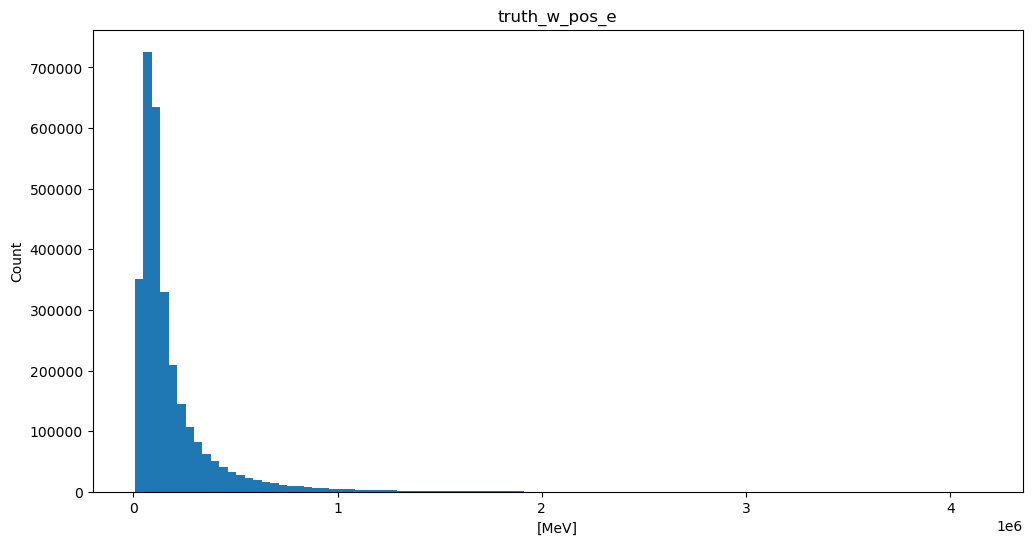

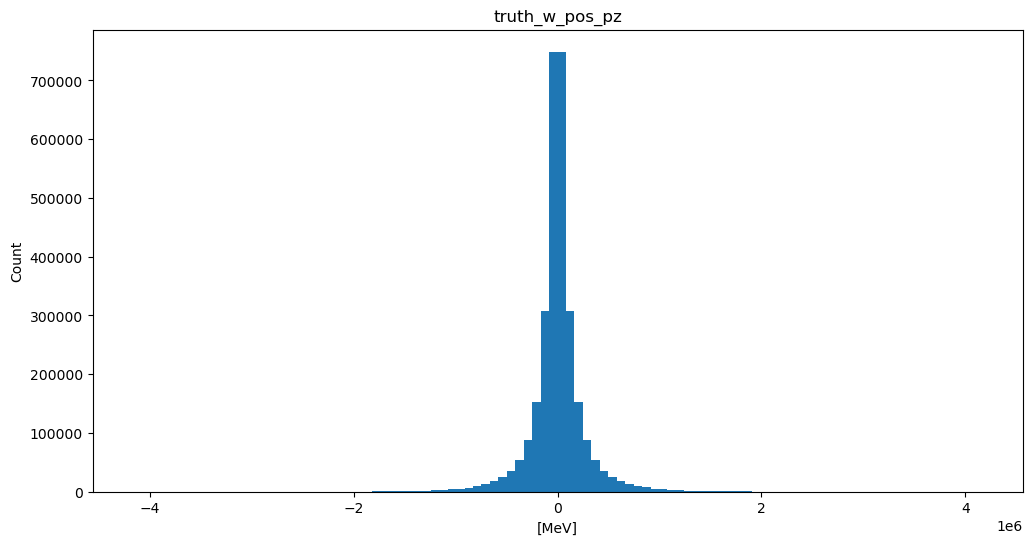

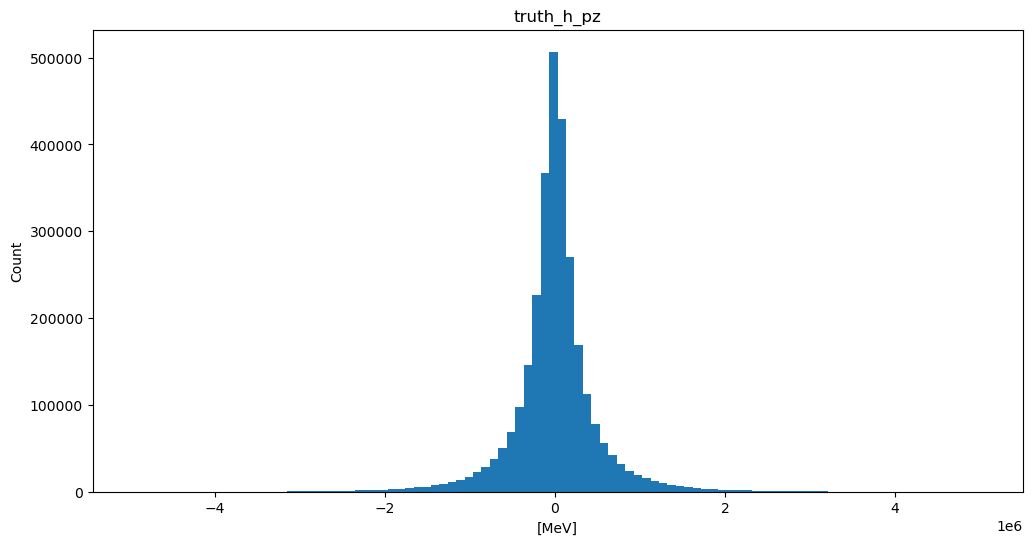

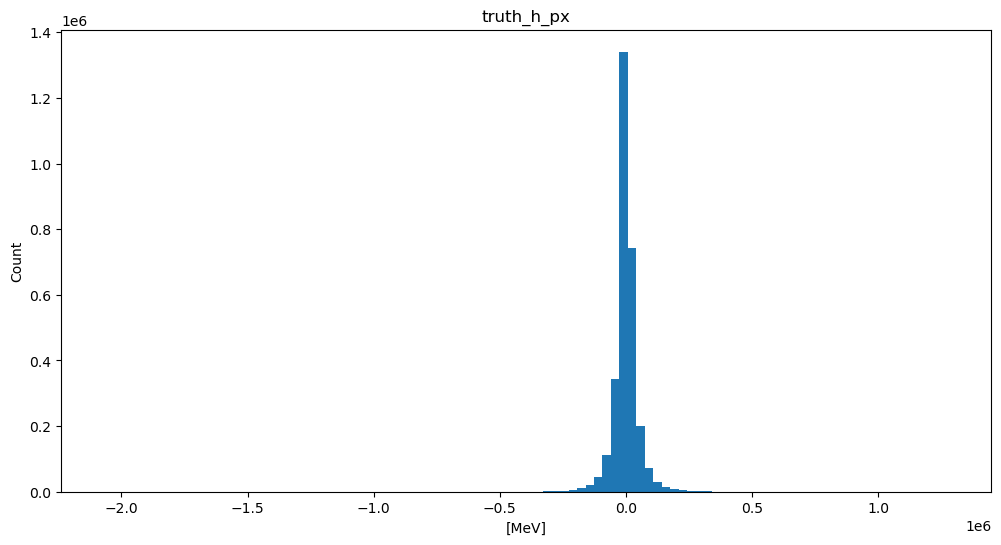

In [16]:
# truth w

truth_w_neg = truth_w1_id[valid_ind]
truth_w_neg_pt = truth_w1_pt[valid_ind]
truth_w_neg_eta = truth_w1_eta[valid_ind]
truth_w_neg_phi = truth_w1_phi[valid_ind]
truth_w_neg_m = truth_w1_m[valid_ind]
# test_plot(truth_w_neg_m, 'truth_w_neg_m')

truth_w_pos = truth_w2_id[valid_ind]
truth_w_pos_pt = truth_w2_pt[valid_ind]
truth_w_pos_eta = truth_w2_eta[valid_ind]
truth_w_pos_phi = truth_w2_phi[valid_ind]
truth_w_pos_m = truth_w2_m[valid_ind]
# test_plot(truth_w_pos_m, 'truth_w_pos_m')

truth_w_neg_px = px(truth_w_neg_pt, truth_w_neg_phi)
truth_w_neg_py = py(truth_w_neg_pt, truth_w_neg_phi)
truth_w_neg_pz = pz(truth_w_neg_pt, truth_w_neg_eta)
truth_w_neg_e = energy(truth_w_neg_pt, truth_w_neg_eta, truth_w_neg_m)
truth_w_pos_px = px(truth_w_pos_pt, truth_w_pos_phi)
truth_w_pos_py = py(truth_w_pos_pt, truth_w_pos_phi)
truth_w_pos_pz = pz(truth_w_pos_pt, truth_w_pos_eta)
truth_w_pos_e = energy(truth_w_pos_pt, truth_w_pos_eta, truth_w_pos_m)
test_plot(truth_w_pos_e, "truth_w_pos_e")
test_plot(truth_w_pos_pz, "truth_w_pos_pz")

# truth h
truth_h_pt = truth_higgs_pt[valid_ind]
truth_h_eta = truth_higgs_eta[valid_ind]
truth_h_phi = truth_higgs_phi[valid_ind]
truth_h_m = truth_higgs_m[valid_ind]
# test_plot(truth_h_m, 'truth_h_m')

truth_h_px = px(truth_h_pt, truth_h_phi)
truth_h_py = py(truth_h_pt, truth_h_phi)
truth_h_pz = pz(truth_h_pt, truth_h_eta)
truth_h_e = energy(truth_h_pt, truth_h_eta, truth_h_m)
test_plot(truth_h_pz, "truth_h_pz")
test_plot(truth_h_px, "truth_h_px")

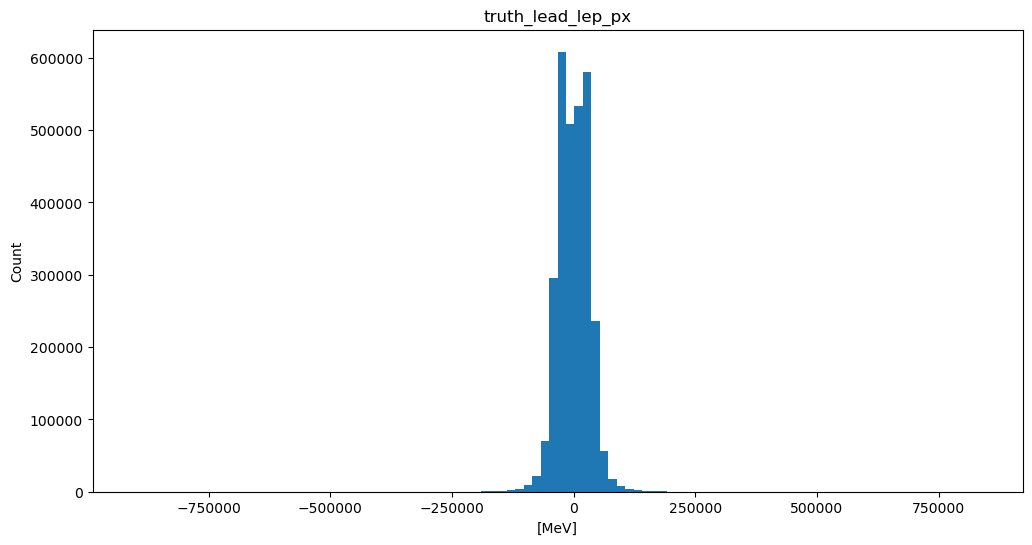

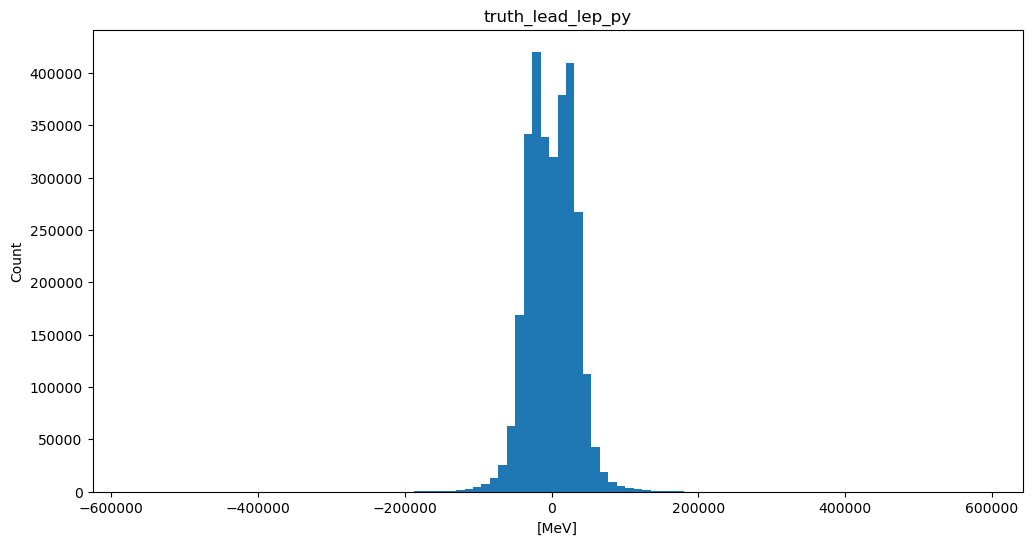

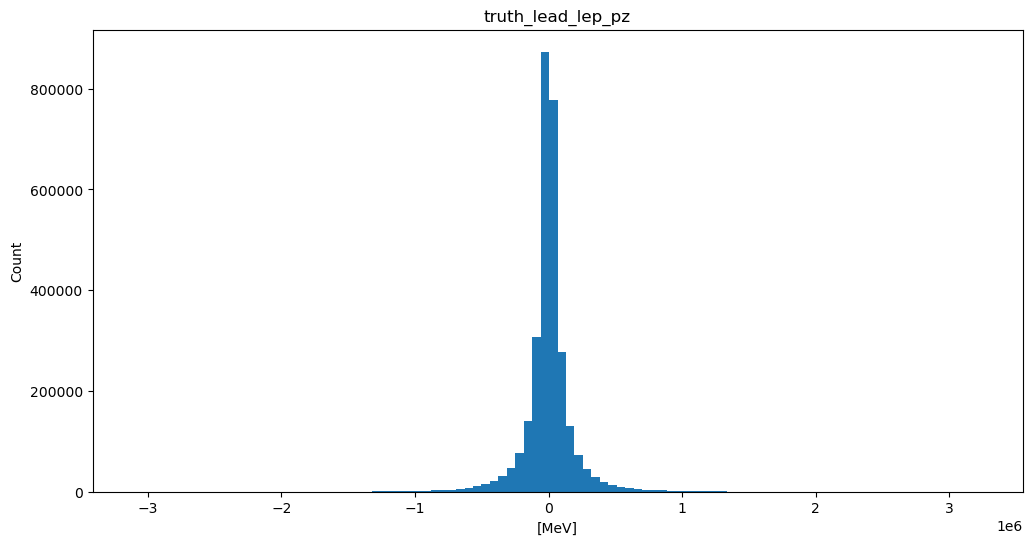

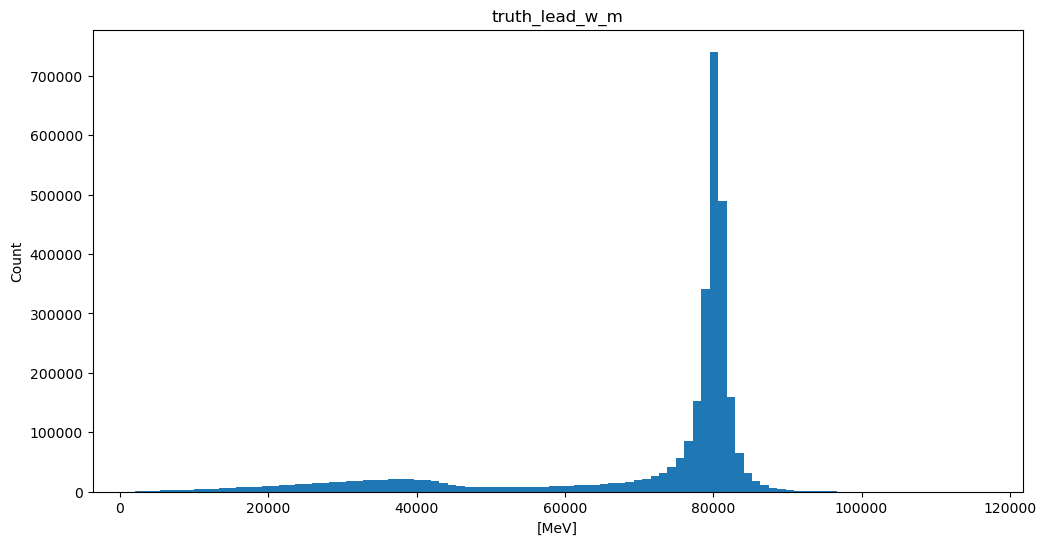

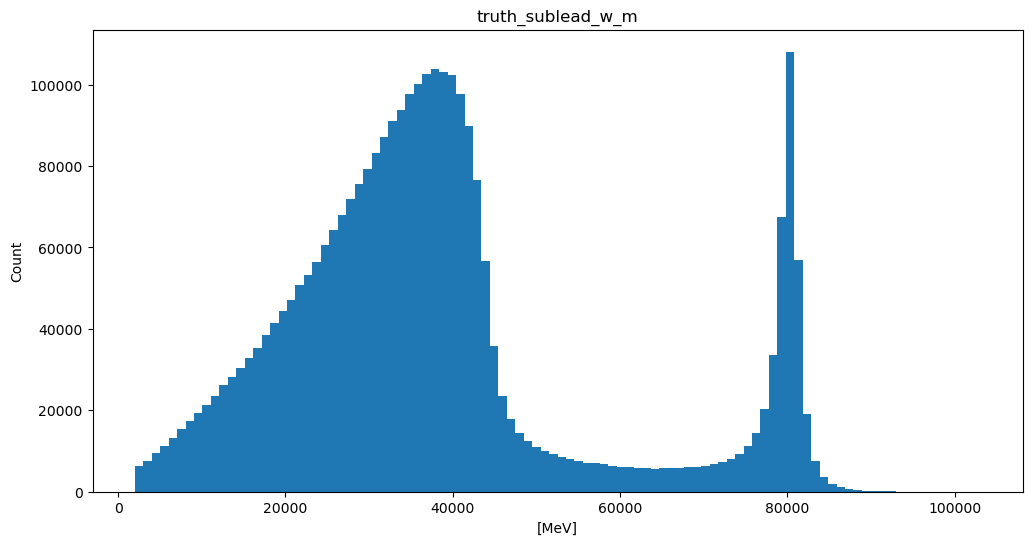

In [17]:
# (sub)lead identification (truth)

neg_leading_mask = truth_lep_neg_pt >= truth_lep_pos_pt

truth_lead_lep_px = np.where(neg_leading_mask, truth_lep_neg_px, truth_lep_pos_px)
truth_lead_lep_py = np.where(neg_leading_mask, truth_lep_neg_py, truth_lep_pos_py)
truth_lead_lep_pz = np.where(neg_leading_mask, truth_lep_neg_pz, truth_lep_pos_pz)
truth_lead_lep_e = np.where(neg_leading_mask, truth_lep_neg_e, truth_lep_pos_e)
truth_lead_lep_pdgId = np.where(neg_leading_mask, truth_lnu12_id[valid_ind], truth_lnu21_id[valid_ind])
test_plot(truth_lead_lep_px, "truth_lead_lep_px")
test_plot(truth_lead_lep_py, "truth_lead_lep_py")
test_plot(truth_lead_lep_pz, "truth_lead_lep_pz")

truth_sublead_lep_px = np.where(neg_leading_mask, truth_lep_pos_px, truth_lep_neg_px)
truth_sublead_lep_py = np.where(neg_leading_mask, truth_lep_pos_py, truth_lep_neg_py)
truth_sublead_lep_pz = np.where(neg_leading_mask, truth_lep_pos_pz, truth_lep_neg_pz)
truth_sublead_lep_e = np.where(neg_leading_mask, truth_lep_pos_e, truth_lep_neg_e)
truth_sublead_lep_pdgId = np.where(neg_leading_mask, truth_lnu21_id[valid_ind], truth_lnu12_id[valid_ind])

truth_sublead_nu_px = np.where(neg_leading_mask, truth_nu_neg_px, truth_nu_pos_px)
truth_sublead_nu_py = np.where(neg_leading_mask, truth_nu_neg_py, truth_nu_pos_py)
truth_sublead_nu_pz = np.where(neg_leading_mask, truth_nu_neg_pz, truth_nu_pos_pz)
truth_sublead_nu_e = np.where(neg_leading_mask, truth_nu_neg_e, truth_nu_pos_e)
truth_sublead_nu_pdgId = np.where(neg_leading_mask, truth_lnu22_id[valid_ind], truth_lnu11_id[valid_ind])

truth_lead_nu_px = np.where(neg_leading_mask, truth_nu_pos_px, truth_nu_neg_px)
truth_lead_nu_py = np.where(neg_leading_mask, truth_nu_pos_py, truth_nu_neg_py)
truth_lead_nu_pz = np.where(neg_leading_mask, truth_nu_pos_pz, truth_nu_neg_pz)
truth_lead_nu_e = np.where(neg_leading_mask, truth_nu_pos_e, truth_nu_neg_e)
truth_lead_nu_pdgId = np.where(neg_leading_mask, truth_lnu11_id[valid_ind], truth_lnu22_id[valid_ind])

truth_lead_w_px = np.where(neg_leading_mask, truth_w_neg_px, truth_w_pos_px)
truth_lead_w_py = np.where(neg_leading_mask, truth_w_neg_py, truth_w_pos_py)
truth_lead_w_pz = np.where(neg_leading_mask, truth_w_neg_pz, truth_w_pos_pz)
truth_lead_w_e = np.where(neg_leading_mask, truth_w_neg_e, truth_w_pos_e)
truth_lead_w_m = np.where(neg_leading_mask, truth_w_neg_m, truth_w_pos_m)
truth_lead_w_pdgId = np.where(neg_leading_mask, truth_w_neg, truth_w_pos)

truth_sublead_w_px = np.where(neg_leading_mask, truth_w_pos_px, truth_w_neg_px)
truth_sublead_w_py = np.where(neg_leading_mask, truth_w_pos_py, truth_w_neg_py)
truth_sublead_w_pz = np.where(neg_leading_mask, truth_w_pos_pz, truth_w_neg_pz)
truth_sublead_w_e = np.where(neg_leading_mask, truth_w_pos_e, truth_w_neg_e)
truth_sublead_w_m = np.where(neg_leading_mask, truth_w_pos_m, truth_w_neg_m)
truth_sublead_w_pdgId = np.where(neg_leading_mask, truth_w_pos, truth_w_neg)
test_plot(truth_lead_w_m, "truth_lead_w_m")
test_plot(truth_sublead_w_m, "truth_sublead_w_m")

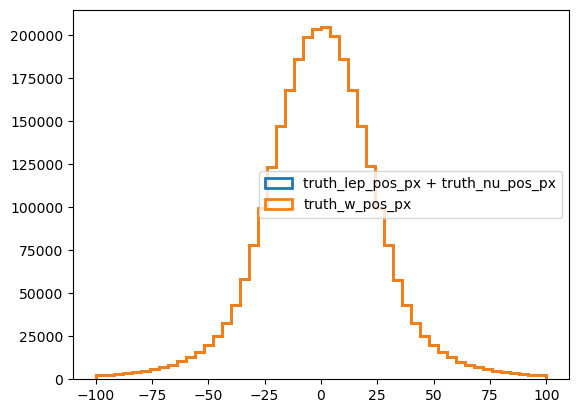

In [18]:
plt.hist((truth_lep_pos_px + truth_nu_neg_px) * 1e-3, bins=np.linspace(-100, 100, 51), label="truth_lep_pos_px + truth_nu_pos_px", histtype='step',  linewidth=2)
plt.hist(truth_w_pos_px * 1e-3, bins=np.linspace(-100, 100, 51), label="truth_w_pos_px", histtype='step',  linewidth=2)
plt.legend()
plt.show()

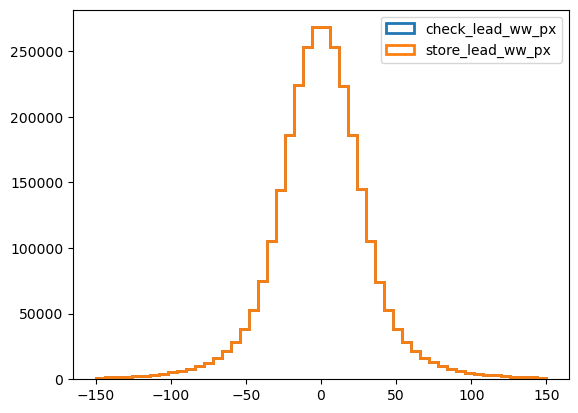

In [19]:
check_truth_ww_px = truth_lead_lep_px + truth_lead_nu_px 
store_truth_ww_px = truth_lead_w_px 
plt.hist(check_truth_ww_px * 1e-3, bins=np.linspace(-150, 150, 51), linewidth=2, histtype="step", label='check_lead_ww_px')
plt.hist(store_truth_ww_px * 1e-3, bins=np.linspace(-150, 150, 51), linewidth=2, histtype="step", label='store_lead_ww_px')
plt.legend()
plt.show()

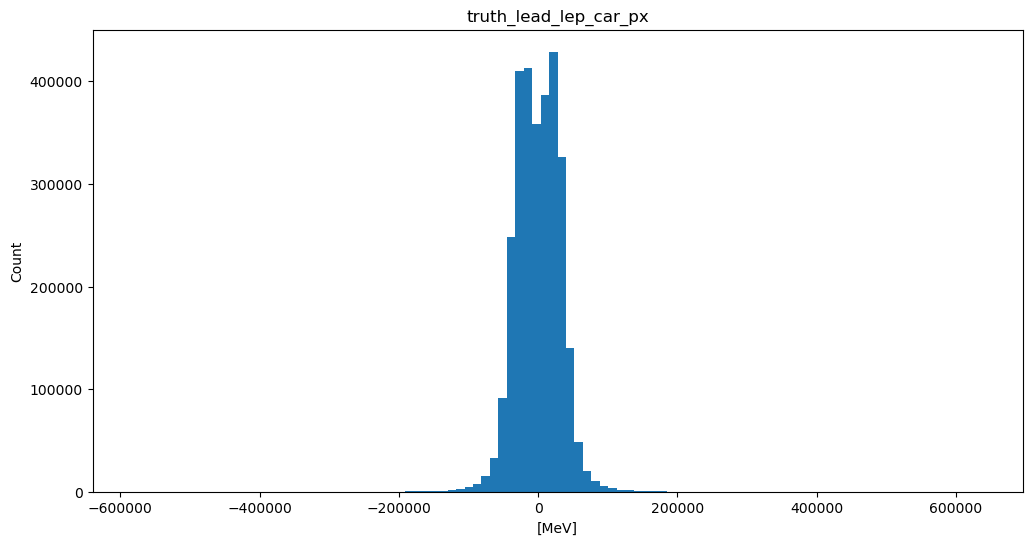

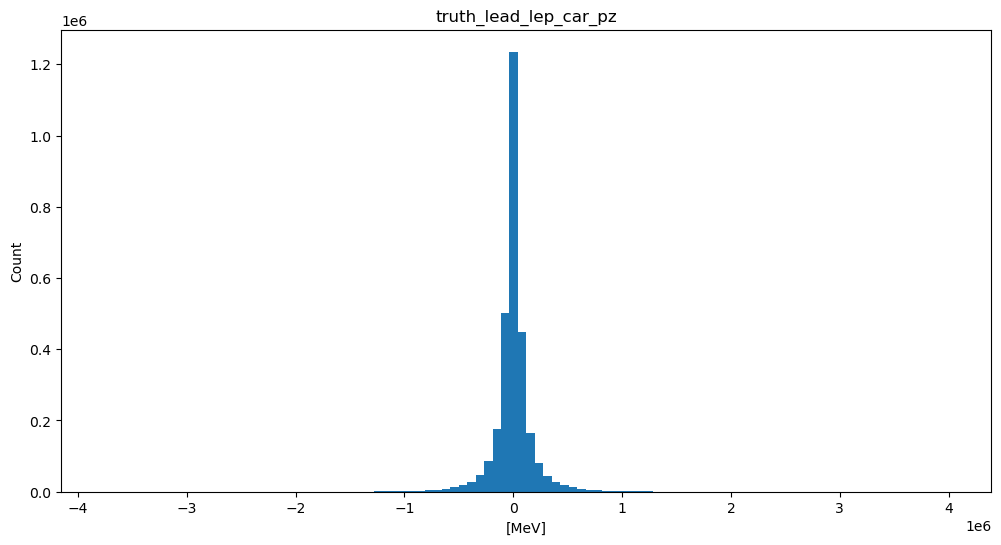

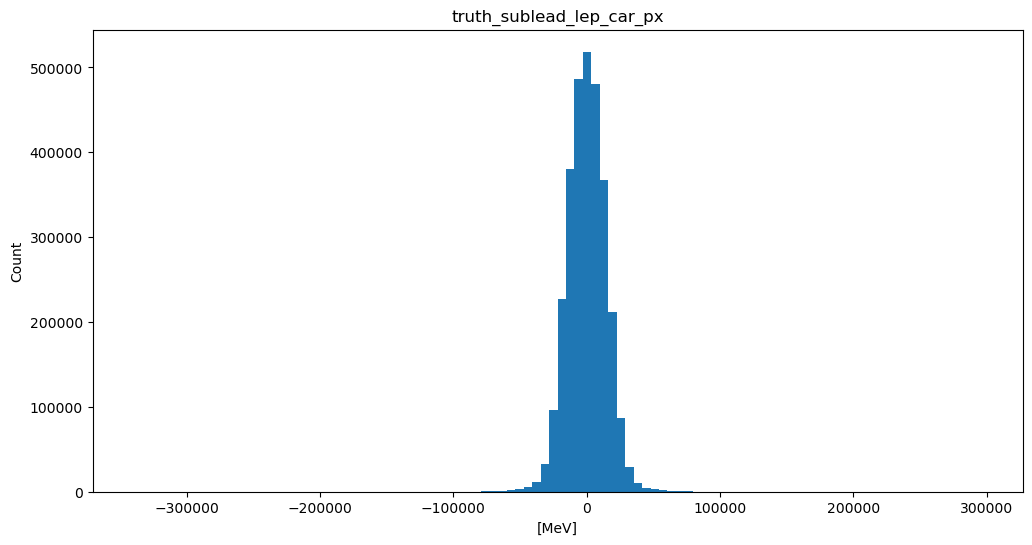

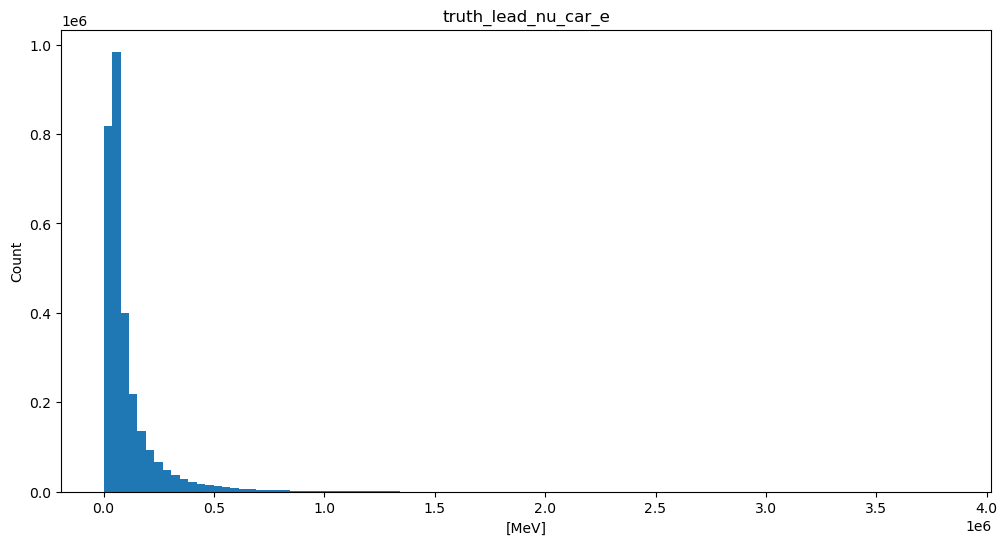

In [20]:
# (sub)lead identification (truth_CAR)

neg_leading_car_mask = truth_lep_neg_car_pt >= truth_lep_pos_car_pt

truth_lead_lep_car_px = np.where(
    neg_leading_car_mask, truth_lep_neg_car_px, truth_lep_pos_car_px
)
truth_lead_lep_car_py = np.where(
    neg_leading_car_mask, truth_lep_neg_car_py, truth_lep_pos_car_py
)
truth_lead_lep_car_pz = np.where(
    neg_leading_car_mask, truth_lep_neg_car_pz, truth_lep_pos_car_pz
)
truth_lead_lep_car_e = np.where(
    neg_leading_car_mask, truth_lep_neg_car_e, truth_lep_pos_car_e
)
truth_lead_lep_car_pdgId = np.where(
    neg_leading_car_mask, truth_lnu12_car_id[valid_ind], truth_lnu21_car_id[valid_ind]
)
test_plot(truth_lead_lep_car_px, "truth_lead_lep_car_px")
test_plot(truth_lead_lep_car_pz, "truth_lead_lep_car_pz")

truth_sublead_lep_car_px = np.where(
    neg_leading_car_mask, truth_lep_pos_car_px, truth_lep_neg_car_px
)
truth_sublead_lep_car_py = np.where(
    neg_leading_car_mask, truth_lep_pos_car_py, truth_lep_neg_car_py
)
truth_sublead_lep_car_pz = np.where(
    neg_leading_car_mask, truth_lep_pos_car_pz, truth_lep_neg_car_pz
)
truth_sublead_lep_car_e = np.where(
    neg_leading_car_mask, truth_lep_pos_car_e, truth_lep_neg_car_e
)
truth_sublead_lep_car_pdgId = np.where(
    neg_leading_car_mask, truth_lnu21_car_id[valid_ind], truth_lnu12_car_id[valid_ind]
)
test_plot(truth_sublead_lep_car_px, "truth_sublead_lep_car_px")

truth_sublead_nu_car_px = np.where(
    neg_leading_car_mask, truth_nu_neg_car_px, truth_nu_pos_car_px
)
truth_sublead_nu_car_py = np.where(
    neg_leading_car_mask, truth_nu_neg_car_py, truth_nu_pos_car_py
)
truth_sublead_nu_car_pz = np.where(
    neg_leading_car_mask, truth_nu_neg_car_pz, truth_nu_pos_car_pz
)
truth_sublead_nu_car_e = np.where(
    neg_leading_car_mask, truth_nu_neg_car_e, truth_nu_pos_car_e
)
truth_sublead_nu_car_pdgId = np.where(
    neg_leading_car_mask, truth_lnu22_car_id[valid_ind], truth_lnu11_car_id[valid_ind]
)

truth_lead_nu_car_px = np.where(
    neg_leading_car_mask, truth_nu_pos_car_px, truth_nu_neg_car_px
)
truth_lead_nu_car_py = np.where(
    neg_leading_car_mask, truth_nu_pos_car_py, truth_nu_neg_car_py
)
truth_lead_nu_car_pz = np.where(
    neg_leading_car_mask, truth_nu_pos_car_pz, truth_nu_neg_car_pz
)
truth_lead_nu_car_e = np.where(
    neg_leading_car_mask, truth_nu_pos_car_e, truth_nu_neg_car_e
)
truth_lead_nu_car_pdgId = np.where(
    neg_leading_car_mask, truth_lnu11_car_id[valid_ind], truth_lnu22_car_id[valid_ind]
)
test_plot(truth_lead_nu_car_e, "truth_lead_nu_car_e")

In [21]:
GEV = 1e-3

def pt(px, py):
    return np.sqrt(np.square(px) + np.square(py))


def eta(px, py, pz):
    pt = np.sqrt(np.square(px) + np.square(py))
    return np.arcsinh(np.divide(pz, pt))


def phi(px, py):
    return np.arctan2(py, px)


def deta(eta1, eta2):
    return np.abs(eta1 - eta2)


def dphi_pi(phi1, phi2):
    phi_diff = phi1 - phi2
    phi_diff = np.where(phi_diff < 0.0, -phi_diff, phi_diff)
    phi_diff = np.where(phi_diff > 2.0 * np.pi, phi_diff - 2.0 * np.pi, phi_diff)
    phi_diff = np.where(phi_diff >= np.pi, 2.0 * np.pi - phi_diff, phi_diff)
    return np.divide(phi_diff, np.pi)


def m(p4):
    return np.sqrt(
        np.square(p4[:, 3])
        - np.square(p4[:, 0])
        - np.square(p4[:, 1])
        - np.square(p4[:, 2])
    )
    

@dataclass
class Truth_lead_lep:
    px = truth_lead_lep_px * GEV
    py = truth_lead_lep_py * GEV
    pz = truth_lead_lep_pz * GEV
    energy = truth_lead_lep_e * GEV
    pt = pt(px, py)
    eta = eta(px, py, pz)
    phi = phi(px, py)
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T
    pdgId = truth_lead_lep_pdgId


@dataclass
class Truth_sublead_lep:
    px = truth_sublead_lep_px * GEV
    py = truth_sublead_lep_py * GEV
    pz = truth_sublead_lep_pz * GEV
    energy = truth_sublead_lep_e * GEV
    pt = pt(px, py)
    eta = eta(px, py, pz)
    phi = phi(px, py)
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T
    pdgId = truth_sublead_lep_pdgId


@dataclass
class Truth_dilep:
    p4 = Truth_lead_lep.p4 + Truth_sublead_lep.p4
    p3 = p4[:, :3]
    px = p4[:, 0]
    py = p4[:, 1]
    pz = p4[:, 2]
    dphi = dphi_pi(
        phi(Truth_lead_lep.px, Truth_lead_lep.py),
        phi(Truth_sublead_lep.px, Truth_sublead_lep.py)
    )
    deta = deta(
        eta(Truth_lead_lep.px, Truth_lead_lep.py, Truth_lead_lep.pz),
        eta(Truth_sublead_lep.px, Truth_sublead_lep.py, Truth_sublead_lep.pz)
    )
    m = m(p4)


@dataclass
class Truth_lead_nu:
    px = truth_lead_nu_px * GEV
    py = truth_lead_nu_py * GEV
    pz = truth_lead_nu_pz * GEV
    energy = truth_lead_nu_e * GEV
    pt = pt(px, py)
    eta = eta(px, py, pz)
    phi = phi(px, py)
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T
    pdgId = truth_lead_nu_pdgId


@dataclass
class Truth_sublead_nu:
    px = truth_sublead_nu_px * GEV
    py = truth_sublead_nu_py * GEV
    pz = truth_sublead_nu_pz * GEV
    energy = truth_sublead_nu_e * GEV
    pt = pt(px, py)
    eta = eta(px, py, pz)
    phi = phi(px, py)
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T
    pdgId = truth_sublead_nu_pdgId


@dataclass
class Truth_lead_lep_CAR:
    px = truth_lead_lep_car_px * GEV
    py = truth_lead_lep_car_py * GEV
    pz = truth_lead_lep_car_pz * GEV
    energy = truth_lead_lep_car_e * GEV
    pt = pt(px, py)
    eta = eta(px, py, pz)
    phi = phi(px, py)
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T
    pdgId = truth_lead_lep_car_pdgId


@dataclass
class Truth_sublead_lep_CAR:
    px = truth_sublead_lep_car_px * GEV
    py = truth_sublead_lep_car_py * GEV
    pz = truth_sublead_lep_car_pz * GEV
    energy = truth_sublead_lep_car_e * GEV
    pt = pt(px, py)
    eta = eta(px, py, pz)
    phi = phi(px, py)
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T


@dataclass
class Truth_dilep_CAR:
    p4 = Truth_lead_lep_CAR.p4 + Truth_sublead_lep_CAR.p4
    p3 = p4[:, :3]
    px = p4[:, 0]
    py = p4[:, 1]
    pz = p4[:, 2]
    deta = deta(
        eta(Truth_lead_lep_CAR.px, Truth_lead_lep_CAR.py, Truth_lead_lep_CAR.pz),
        eta(Truth_sublead_lep_CAR.px, Truth_sublead_lep_CAR.py, Truth_sublead_lep_CAR.pz)
    )
    dphi = dphi_pi(
        phi(Truth_lead_lep_CAR.px, Truth_lead_lep_CAR.py),
        phi(Truth_sublead_lep_CAR.px, Truth_sublead_lep_CAR.py)
    )
    m = m(p4)


@dataclass
class Truth_lead_nu_CAR:
    px = truth_lead_nu_car_px * GEV
    py = truth_lead_nu_car_py * GEV
    pz = truth_lead_nu_car_pz * GEV
    energy = truth_lead_nu_car_e * GEV
    pt = pt(px, py)
    eta = eta(px, py, pz)
    phi = phi(px, py)
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T
    pdgId = truth_lead_nu_car_pdgId


@dataclass
class Truth_sublead_nu_CAR:
    px = truth_sublead_nu_car_px * GEV
    py = truth_sublead_nu_car_py * GEV
    pz = truth_sublead_nu_car_pz * GEV
    energy = truth_sublead_nu_car_e * GEV
    pt = pt(px, py)
    eta = eta(px, py, pz)
    phi = phi(px, py)
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T
    pdgId = truth_sublead_nu_car_pdgId


@dataclass
class Lead_w:
    px = truth_lead_w_px * GEV
    py = truth_lead_w_py * GEV
    pz = truth_lead_w_pz * GEV
    energy = truth_lead_w_e * GEV
    pt = pt(px, py)
    eta = eta(px, py, pz)
    phi = phi(px, py)
    m = truth_lead_w_m * GEV
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T
    pdgId = truth_lead_w_pdgId


@dataclass
class Sublead_w:
    px = truth_sublead_w_px * GEV
    py = truth_sublead_w_py * GEV
    pz = truth_sublead_w_pz * GEV
    energy = truth_sublead_w_e * GEV
    pt = pt(px, py)
    eta = eta(px, py, pz)
    phi = phi(px, py)
    m = truth_sublead_w_m * GEV
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T
    pdgId = truth_sublead_w_pdgId
    

@dataclass
class Higgs:
    px = truth_h_px * GEV
    py = truth_h_py * GEV
    pz = truth_h_pz * GEV
    energy = truth_h_e * GEV
    pt = pt(px, py)
    eta = eta(px, py, pz)
    phi = phi(px, py)
    m = truth_h_m * GEV
    p4 = np.array([px, py, pz, energy]).T
    p3 = np.array([px, py, pz]).T


if __name__ == "__main__":
    print(Truth_lead_lep)
    print(Truth_sublead_lep)
    print(Truth_dilep)
    print(Truth_lead_nu)
    print(Truth_sublead_nu)
    print(Lead_w)
    print(Sublead_w)
    print(Higgs)

/tmp/ipykernel_1529072/933479176.py:29: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(


<class '__main__.Truth_lead_lep'>
<class '__main__.Truth_sublead_lep'>
<class '__main__.Truth_dilep'>
<class '__main__.Truth_lead_nu'>
<class '__main__.Truth_sublead_nu'>
<class '__main__.Lead_w'>
<class '__main__.Sublead_w'>
<class '__main__.Higgs'>


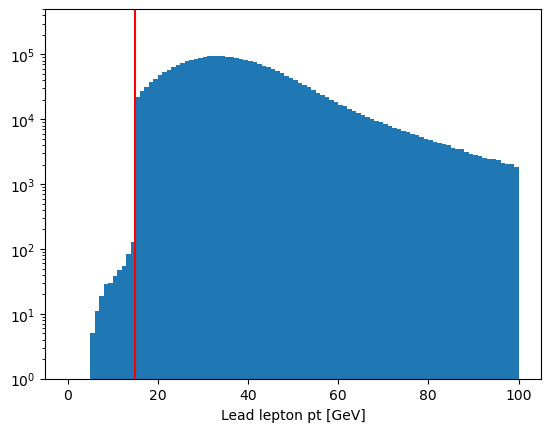

2.6344006


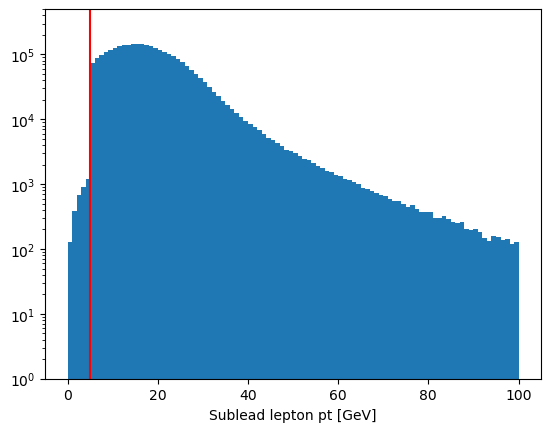

0.10892227


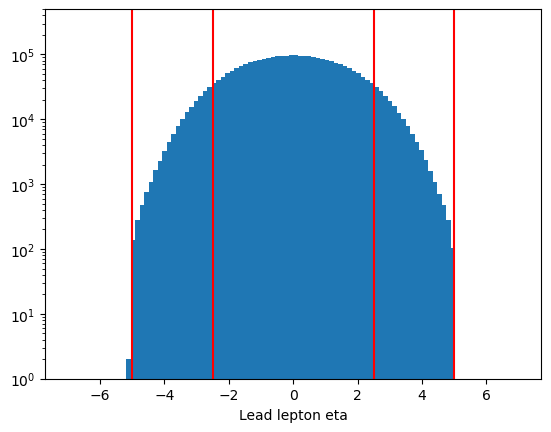

-5.1976433


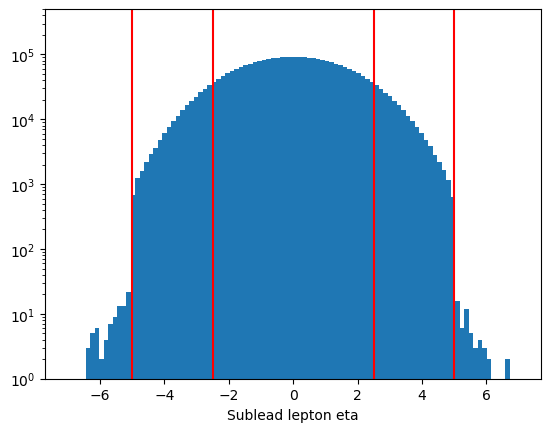

-6.9070086


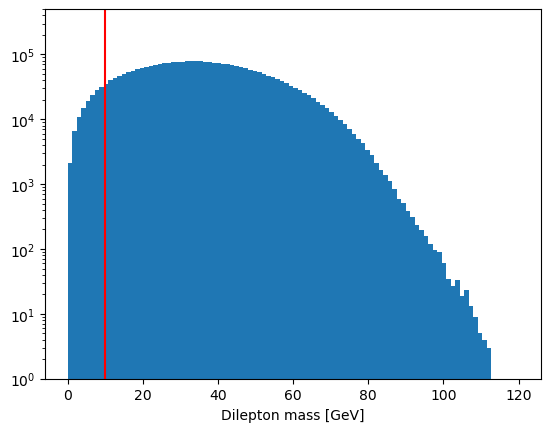

-6.9070086


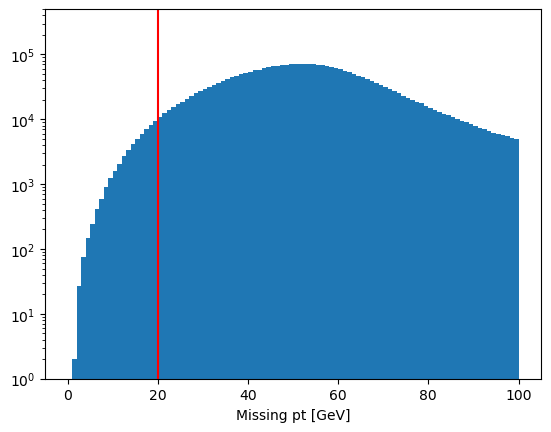

1.7796066


In [22]:
# truth check

plt.hist(Truth_lead_lep.pt, bins=np.linspace(0,100,101))
plt.vlines(15, 0, 1e10, colors='r')
plt.semilogy()
plt.ylim(1, 5e5)
plt.xlabel("Lead lepton pt [GeV]")
plt.show()
print(Truth_lead_lep.pt.min())

plt.hist(Truth_sublead_lep.pt, bins=np.linspace(0,100,101))
plt.vlines(5, 0, 1e10, colors='r')
plt.semilogy()
plt.ylim(1, 5e5)
plt.xlabel("Sublead lepton pt [GeV]")
plt.show()
print(Truth_sublead_lep.pt.min())

plt.hist(Truth_lead_lep.eta, bins=np.linspace(-7,7,101))
plt.vlines(5, 0, 1e10, colors='r')
plt.vlines(2.5, 0, 1e10, colors='r')
plt.vlines(-2.5, 0, 1e10, colors='r')
plt.vlines(-5, 0, 1e10, colors='r')
plt.semilogy()
plt.ylim(1, 5e5)
plt.xlabel("Lead lepton eta")
plt.show()
print(Truth_lead_lep.eta.min())

plt.hist(Truth_sublead_lep.eta, bins=np.linspace(-7,7,101))
plt.vlines(5, 0, 1e10, colors='r')
plt.vlines(2.5, 0, 1e10, colors='r')
plt.vlines(-2.5, 0, 1e10, colors='r')
plt.vlines(-5, 0, 1e10, colors='r')
plt.semilogy()
plt.ylim(1, 5e5)
plt.xlabel("Sublead lepton eta")
plt.show()
print(Truth_sublead_lep.eta.min())

plt.hist(Truth_dilep.m, bins=np.linspace(0,120,101))
plt.vlines(10, 0, 1e10, colors='r')
# plt.vlines(-2.5, 0, 1e10, colors='r')
plt.semilogy()
plt.ylim(1, 5e5)
plt.xlabel("Dilepton mass [GeV]")
plt.show()
print(Truth_sublead_lep.eta.min())

miss_pt = Truth_lead_nu.pt + Truth_sublead_nu.pt
plt.hist(miss_pt, bins=np.linspace(0, 100, 101))
plt.vlines(20, 0, 1e10, colors='r')
plt.semilogy()
plt.ylim(1, 5e5)
plt.xlabel("Missing pt [GeV]")
plt.show()
print(miss_pt.min())

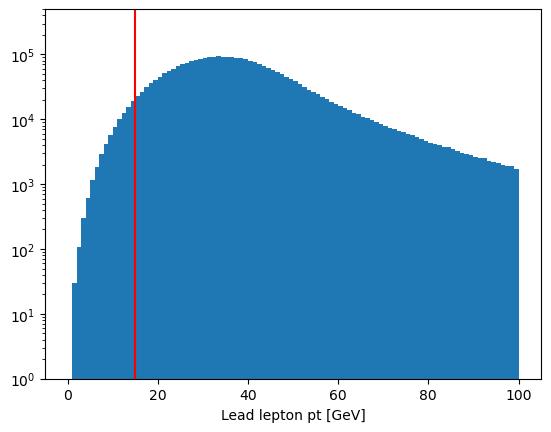

0.8356871


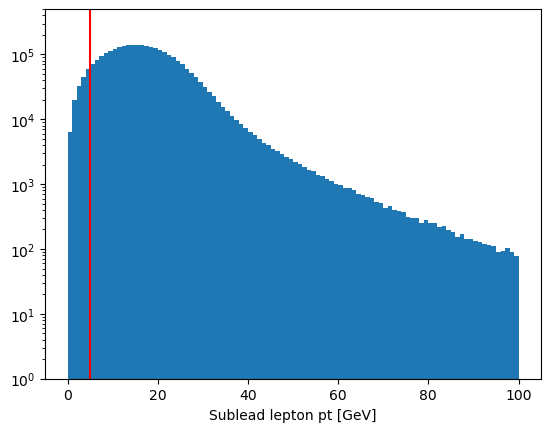

0.013572426


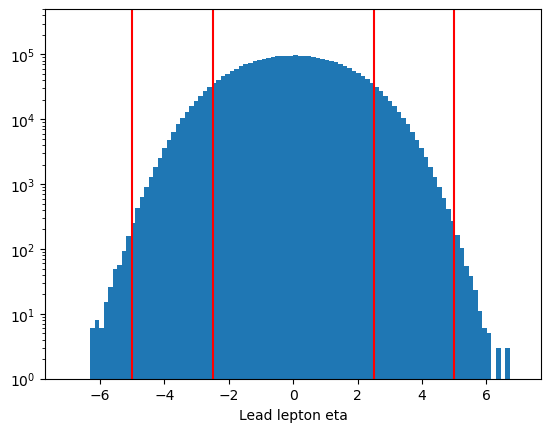

-6.2475066


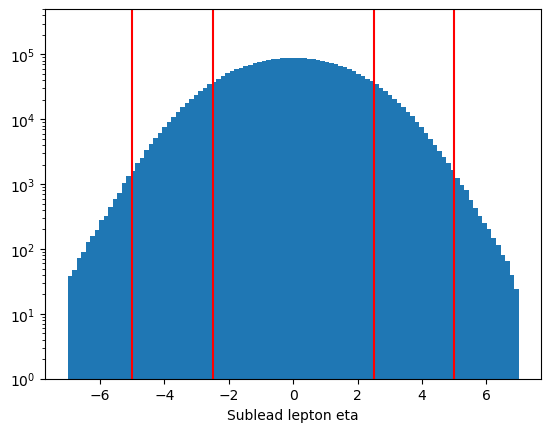

-9.691063


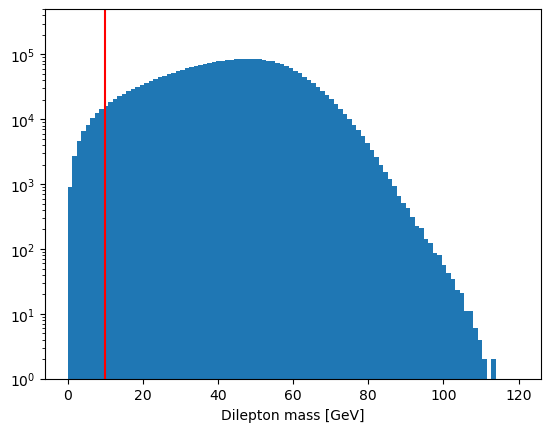

-9.691063


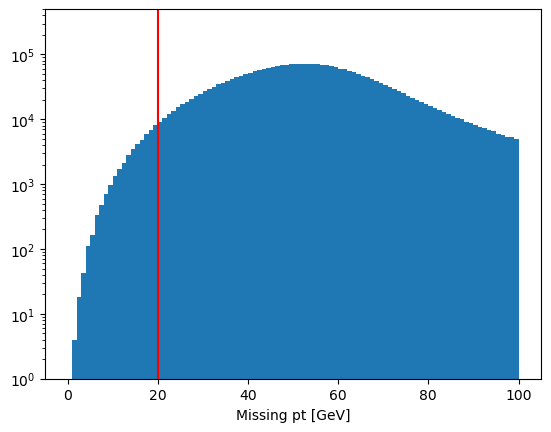

1.1503782


In [23]:
# truth check

plt.hist(Truth_lead_lep_CAR.pt, bins=np.linspace(0,100,101))
plt.vlines(15, 0, 1e10, colors='r')
plt.semilogy()
plt.ylim(1, 5e5)
plt.xlabel("Lead lepton pt [GeV]")
plt.show()
print(Truth_lead_lep_CAR.pt.min())

plt.hist(Truth_sublead_lep_CAR.pt, bins=np.linspace(0,100,101))
plt.vlines(5, 0, 1e10, colors='r')
plt.semilogy()
plt.ylim(1, 5e5)
plt.xlabel("Sublead lepton pt [GeV]")
plt.show()
print(Truth_sublead_lep_CAR.pt.min())

plt.hist(Truth_lead_lep_CAR.eta, bins=np.linspace(-7,7,101))
plt.vlines(5, 0, 1e10, colors='r')
plt.vlines(2.5, 0, 1e10, colors='r')
plt.vlines(-2.5, 0, 1e10, colors='r')
plt.vlines(-5, 0, 1e10, colors='r')
plt.semilogy()
plt.ylim(1, 5e5)
plt.xlabel("Lead lepton eta")
plt.show()
print(Truth_lead_lep_CAR.eta.min())

plt.hist(Truth_sublead_lep_CAR.eta, bins=np.linspace(-7,7,101))
plt.vlines(5, 0, 1e10, colors='r')
plt.vlines(2.5, 0, 1e10, colors='r')
plt.vlines(-2.5, 0, 1e10, colors='r')
plt.vlines(-5, 0, 1e10, colors='r')
plt.semilogy()
plt.ylim(1, 5e5)
plt.xlabel("Sublead lepton eta")
plt.show()
print(Truth_sublead_lep_CAR.eta.min())

plt.hist(Truth_dilep_CAR.m, bins=np.linspace(0,120,101))
# plt.vlines(2.5, 0, 1e10, colors='r')
plt.vlines(10, 0, 1e10, colors='r')
plt.semilogy()
plt.ylim(1, 5e5)
plt.xlabel("Dilepton mass [GeV]")
plt.show()
print(Truth_sublead_lep_CAR.eta.min())

miss_pt = Truth_lead_nu_CAR.pt + Truth_sublead_nu_CAR.pt
plt.hist(miss_pt, bins=np.linspace(0, 100, 101))
plt.vlines(20, 0, 1e10, colors='r')
plt.semilogy()
plt.ylim(1, 5e5)
plt.xlabel("Missing pt [GeV]")
plt.show()
print(miss_pt.min())

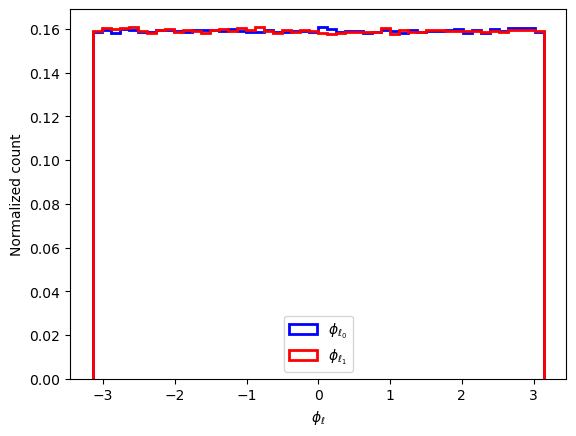

In [24]:
fig = plt.Figure(figsize=(12, 6), dpi=120)
bins_edge = np.linspace(-np.pi, np.pi, 51)
plt.hist(
    Truth_lead_lep().phi,
    bins=bins_edge,
    histtype="step",
    color="blue",
    linewidth=2,
    label=r"$\phi_{\ell_0}$",
    density=True,
)
plt.hist(
    Truth_sublead_lep().phi,
	bins=bins_edge,
	histtype="step",
	color="red",
	linewidth=2,
	label=r"$\phi_{\ell_1}$",
	density=True,
)
plt.legend(loc="best")
plt.xlabel(r"$\phi_{\ell}$")
plt.ylabel("Normalized count")
plt.show()

In [25]:
higgs_20_mask = Higgs.pt < 20

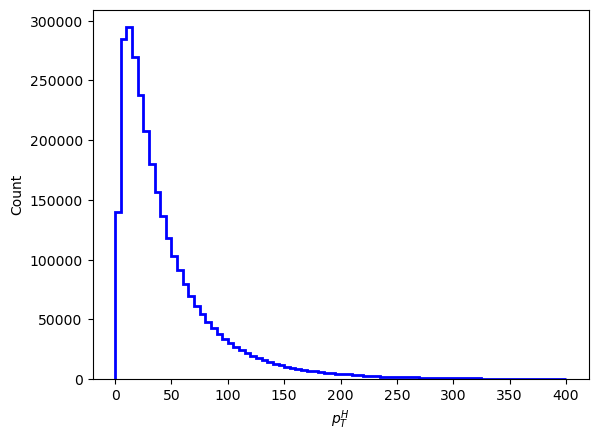

In [26]:
fig = plt.Figure(figsize=(12, 6), dpi=200)
bins_edge = np.linspace(0, 400, 81)
plt.hist(
    Higgs.pt,
    bins=bins_edge,
    histtype="step",
    color="blue",
    linewidth=2,
    density=False,
)
plt.xlabel(r"$p_T^H$")
plt.ylabel("Count")
plt.show()

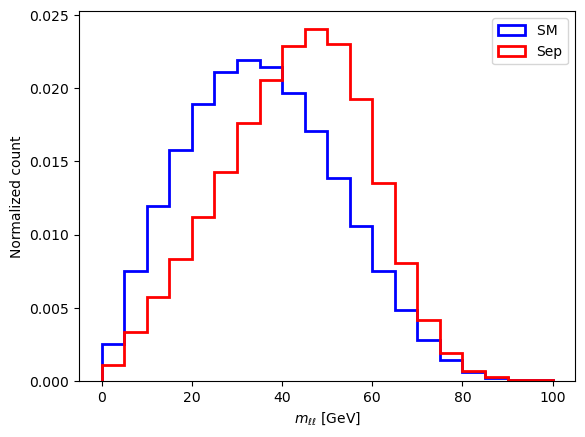

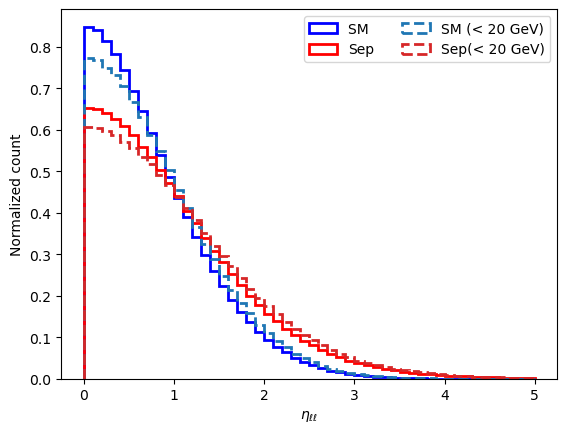

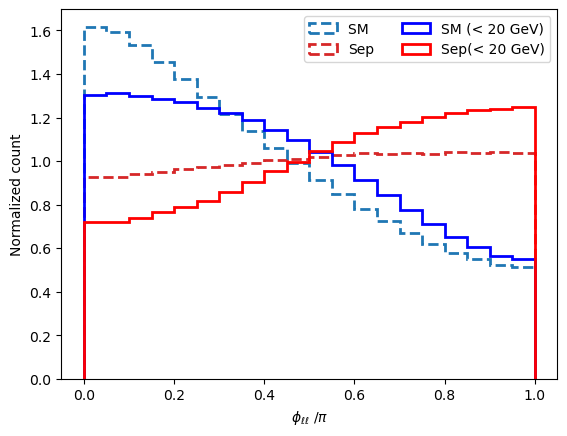

In [27]:
fig = plt.Figure(figsize=(12, 6), dpi=120)
bins_edge = np.linspace(0, 100, 21)
plt.hist(
    Truth_dilep().m,
    bins=bins_edge,
    histtype="step",
    color="blue",
    linewidth=2,
    label="SM ",
    density=True,
)
plt.hist(
    Truth_dilep_CAR().m,
    bins=bins_edge,
    histtype="step",
    color="red",
    linewidth=2,
    label="Sep",
    density=True,
)
plt.legend(loc="best")
plt.xlabel(r"$m_{\ell \ell}$ [GeV]")
plt.ylabel("Normalized count")
plt.show()

fig = plt.Figure(figsize=(12, 6), dpi=120)
bins_edge = np.linspace(0, 5, 51)
plt.hist(
    Truth_dilep().deta,
    bins=bins_edge,
    histtype="step",
    color="blue",
    linewidth=2,
    label="SM ",
    density=True,
)
plt.hist(
    Truth_dilep_CAR().deta,
    bins=bins_edge,
    histtype="step",
    color="red",
    linewidth=2,
    label="Sep",
    density=True,
)
plt.hist(
    Truth_dilep().deta[higgs_20_mask],
    bins=bins_edge,
    histtype="step",
    linestyle="--",
    color="tab:blue",
    linewidth=2,
    label="SM (< 20 GeV)",
    density=True,
)
plt.hist(
    Truth_dilep_CAR().deta[higgs_20_mask],
    bins=bins_edge,
    histtype="step",
    linestyle="--",
    color="tab:red",
    linewidth=2,
    label="Sep(< 20 GeV)",
    density=True,
)
plt.legend(loc="best", ncol=2)
plt.xlabel(r"$\eta_{\ell \ell}$")
plt.ylabel("Normalized count")
plt.show()

fig = plt.Figure(figsize=(12, 6), dpi=120)
bins_edge = np.linspace(0, 1, 21)
plt.hist(
    Truth_dilep().dphi,
    bins=bins_edge,
    histtype="step",
    linestyle="--",
    color="tab:blue",
    linewidth=2,
    label="SM ",
    density=True,
)
plt.hist(
    Truth_dilep_CAR().dphi,
    bins=bins_edge,
    histtype="step",
    linestyle="--",
    color="tab:red",
    linewidth=2,
    label="Sep",
    density=True,
)
plt.hist(
    Truth_dilep().dphi[higgs_20_mask],
    bins=bins_edge,
    histtype="step",
    linestyle="-",
    color="blue",
    linewidth=2,
    label="SM (< 20 GeV)",
    density=True,
)
plt.hist(
    Truth_dilep_CAR().dphi[higgs_20_mask],
    bins=bins_edge,
    histtype="step",
    linestyle="-",
    color="red",
    linewidth=2,
    label="Sep(< 20 GeV)",
    density=True,
)
plt.legend(loc="best", ncol=2)
plt.xlabel(r"$\phi_{\ell \ell}\ / \pi$")
plt.ylabel("Normalized count")
plt.show()

2959864
2963488
2736420
2963488


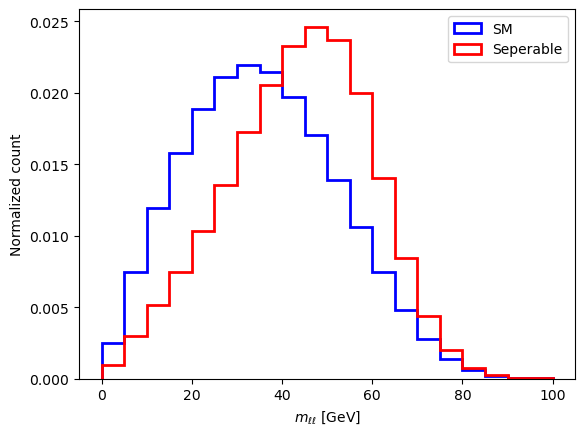

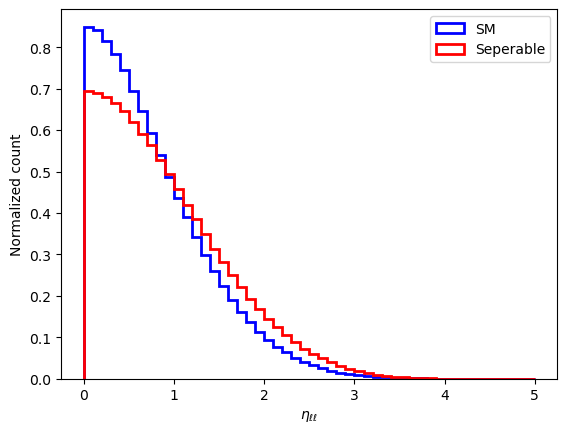

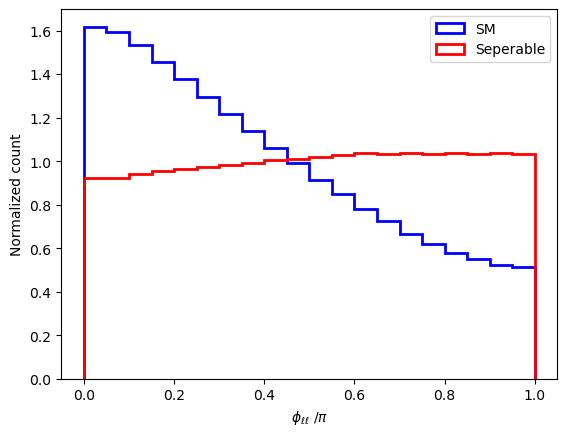

In [28]:
baseline_lead_pt_mask = Truth_lead_lep.pt > 15
baseline_sublead_pt_mask = Truth_sublead_lep.pt > 5
truth_mask = baseline_lead_pt_mask & baseline_sublead_pt_mask
print(np.sum(truth_mask*1))
print(len(truth_mask))

baseline_lead_pt_car_mask = Truth_lead_lep_CAR.pt > 15
baseline_sublead_pt_car_mask = Truth_sublead_lep_CAR.pt > 5
car_mask = baseline_lead_pt_car_mask & baseline_sublead_pt_car_mask
print(np.sum(car_mask*1))
print(len(car_mask))

fig = plt.Figure(figsize=(12, 6), dpi=120)
bins_edge = np.linspace(0, 100, 21)
plt.hist(
    Truth_dilep().m[truth_mask],
    bins=bins_edge,
    histtype="step",
    color="blue",
    linewidth=2,
    label="SM",
    density=True,
)
plt.hist(
    Truth_dilep_CAR().m[car_mask],
    bins=bins_edge,
    histtype="step",
    color="red",
    linewidth=2,
    label="Seperable",
    density=True,
)
plt.legend(loc="best")
plt.xlabel(r"$m_{\ell \ell}$ [GeV]")
plt.ylabel("Normalized count")
plt.show()

fig = plt.Figure(figsize=(12, 6), dpi=120)
bins_edge = np.linspace(0, 5, 51)
plt.hist(
    Truth_dilep().deta[truth_mask],
    bins=bins_edge,
    histtype="step",
    color="blue",
    linewidth=2,
    label="SM",
    density=True,
)
plt.hist(
    Truth_dilep_CAR().deta[car_mask],
    bins=bins_edge,
    histtype="step",
    color="red",
    linewidth=2,
    label="Seperable",
    density=True,
)
plt.legend(loc="best")
plt.xlabel(r"$\eta_{\ell \ell}$")
plt.ylabel("Normalized count")
plt.show()

fig = plt.Figure(figsize=(12, 6), dpi=120)
bins_edge = np.linspace(0, 1, 21)
plt.hist(
    Truth_dilep().dphi[truth_mask],
    bins=bins_edge,
    histtype="step",
    color="blue",
    linewidth=2,
    label="SM",
    density=True,
)
plt.hist(
    Truth_dilep_CAR().dphi[car_mask],
    bins=bins_edge,
    histtype="step",
    color="red",
    linewidth=2,
    label="Seperable",
    density=True,
)
plt.legend(loc="best")
plt.xlabel(r"$\phi_{\ell \ell}\ / \pi$")
plt.ylabel("Normalized count")
plt.show()

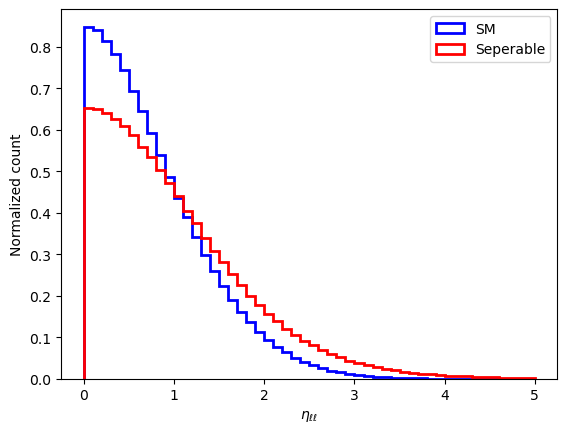

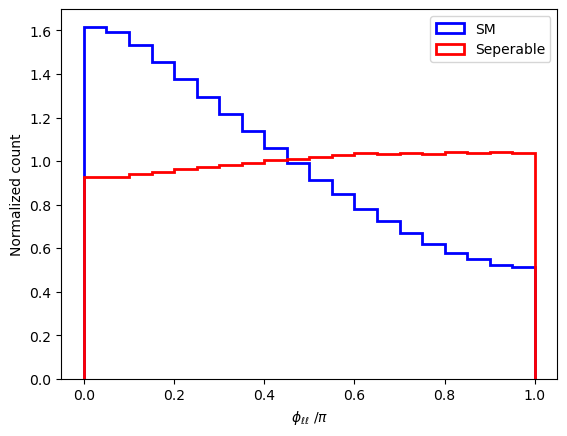

In [29]:
# selected with effective events and preselections
detall_charge = deta(truth_lep_pos_eta, truth_lep_neg_eta)
dphi_charge = dphi_pi(truth_lep_pos_phi, truth_lep_neg_phi)
detall_charge_car = deta(truth_lep_pos_car_eta, truth_lep_neg_car_eta)
dphi_charge_car = dphi_pi(truth_lep_pos_car_phi, truth_lep_neg_car_phi)



fig = plt.Figure(figsize=(12, 6), dpi=120)
bins_edge = np.linspace(0, 5, 51)
plt.hist(
    detall_charge,
    bins=bins_edge,
    histtype="step",
    color="blue",
    linewidth=2,
    label="SM",
    density=True,
)
plt.hist(
    detall_charge_car,
    bins=bins_edge,
    histtype="step",
    color="red",
    linewidth=2,
    label="Seperable",
    density=True,
)
plt.legend(loc="best")
plt.xlabel(r"$\eta_{\ell \ell}$")
plt.ylabel("Normalized count")
plt.show()

fig = plt.Figure(figsize=(12, 6), dpi=120)
bins_edge = np.linspace(0, 1, 21)
plt.hist(
    dphi_charge,
    bins=bins_edge,
    histtype="step",
    color="blue",
    linewidth=2,
    label="SM",
    density=True,
)
plt.hist(
    dphi_charge_car,
    bins=bins_edge,
    histtype="step",
    color="red",
    linewidth=2,
    label="Seperable",
    density=True,
)
plt.legend(loc="best")
plt.xlabel(r"$\phi_{\ell \ell}\ / \pi$")
plt.ylabel("Normalized count")
plt.show()

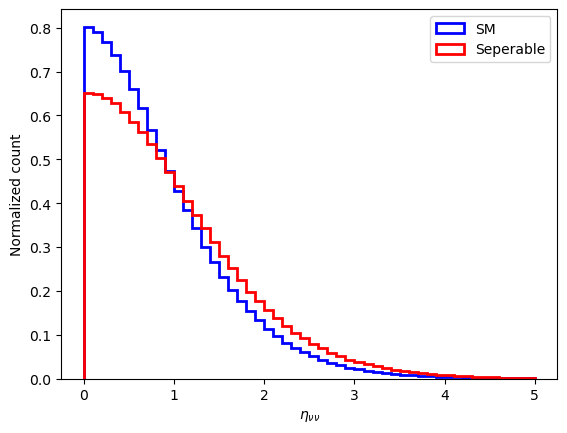

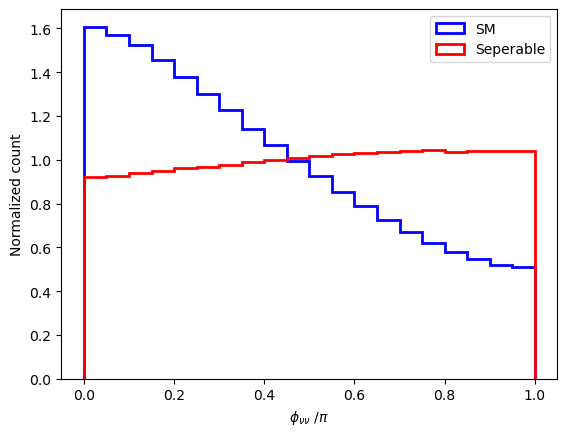

In [30]:
# selected with effective events and preselections
detall_charge = deta(truth_nu_pos_eta, truth_nu_neg_eta)
dphi_charge = dphi_pi(truth_nu_pos_phi, truth_nu_neg_phi)
detall_charge_car = deta(truth_nu_pos_car_eta, truth_nu_neg_car_eta)
dphi_charge_car = dphi_pi(truth_nu_pos_car_phi, truth_nu_neg_car_phi)


fig = plt.Figure(figsize=(12, 6), dpi=120)
bins_edge = np.linspace(0, 5, 51)
plt.hist(
    detall_charge,
    bins=bins_edge,
    histtype="step",
    color="blue",
    linewidth=2,
    label="SM",
    density=True,
)
plt.hist(
    detall_charge_car,
    bins=bins_edge,
    histtype="step",
    color="red",
    linewidth=2,
    label="Seperable",
    density=True,
)
plt.legend(loc="best")
plt.xlabel(r"$\eta_{\nu\nu}$")
plt.ylabel("Normalized count")
plt.show()

fig = plt.Figure(figsize=(12, 6), dpi=120)
bins_edge = np.linspace(0, 1, 21)
plt.hist(
    dphi_charge,
    bins=bins_edge,
    histtype="step",
    color="blue",
    linewidth=2,
    label="SM",
    density=True,
)
plt.hist(
    dphi_charge_car,
    bins=bins_edge,
    histtype="step",
    color="red",
    linewidth=2,
    label="Seperable",
    density=True,
)
plt.legend(loc="best")
plt.xlabel(r"$\phi_{\nu\nu}\ / \pi$")
plt.ylabel("Normalized count")
plt.show()

In [31]:
import h5py
import numpy as np
from dataclasses import fields, is_dataclass

def save_dataclasses_to_h5(filename, **dataclasses_dict):
    """
    Save dataclasses to an HDF5 file
    
    Args:
        filename: Path to the output HDF5 file
        **dataclasses_dict: Keyword arguments with names and dataclass instances
    """
    with h5py.File(filename, 'w') as f:
        # For each dataclass
        for group_name, dataclass_instance in dataclasses_dict.items():
            # Create a group for this dataclass
            group = f.create_group(group_name)
            
            # Get all attributes that aren't special methods
            for attr_name in dir(dataclass_instance):
                if not attr_name.startswith('_'):  # Skip private attributes
                    try:
                        attr_value = getattr(dataclass_instance, attr_name)
                        
                        # Handle numpy arrays
                        if isinstance(attr_value, np.ndarray):
                            group.create_dataset(attr_name, data=attr_value, compression="gzip")
                        # Handle scalars
                        elif np.isscalar(attr_value):
                            group.attrs[attr_name] = attr_value
                    except Exception as e:
                        print(f"Error saving {group_name}.{attr_name}: {e}")

# Usage example - add this at the end of your file
if __name__ == "__main__":
    # Import required libraries at the top of your file
    import numpy as np
    from dataclasses import dataclass
    import h5py
    
    # After your dataclass definitions and initializations
    
    def save_particles_to_h5(filename="/root/data/mc20_truth.h5"):
        """Save all particle dataclasses to H5 file"""
        save_dataclasses_to_h5(
            filename,
            truth_lead_lep=Truth_lead_lep,
            truth_sublead_lep=Truth_sublead_lep,
            truth_dilep=Truth_dilep,
            truth_lead_nu=Truth_lead_nu,
            truth_sublead_nu=Truth_sublead_nu,
            truth_lead_lep_car=Truth_lead_lep_CAR,
            truth_sublead_lep_car=Truth_sublead_lep_CAR,
            truth_dilep_car=Truth_dilep_CAR,
            truth_lead_nu_car=Truth_lead_nu_CAR,
            truth_sublead_nu_car=Truth_sublead_nu_CAR,
            lead_w=Lead_w,
            sublead_w=Sublead_w,
            higgs=Higgs
        )
        print(f"Successfully saved particle data to {filename}")
    
    # Call the function to save the data
    save_particles_to_h5()

Successfully saved particle data to /root/data/mc20_truth.h5


In [32]:
def load_particles_from_h5(filename="/root/data/mc20_truth.h5"):
    """
    Load particle data from an HDF5 file
    
    Args:
        filename: Path to the HDF5 file
        
    Returns:
        Dictionary with the loaded data
    """
    result = {}
    
    with h5py.File(filename, 'r') as f:
        # For each group in the file
        for group_name in f.keys():
            group_data = {}
            
            # Load datasets (numpy arrays)
            for dataset_name in f[group_name].keys():
                group_data[dataset_name] = f[group_name][dataset_name][:]
            
            # Load attributes (scalars)
            for attr_name, attr_value in f[group_name].attrs.items():
                group_data[attr_name] = attr_value
            
            result[group_name] = group_data
            
    return result

In [33]:
load_particles_from_h5().keys()

dict_keys(['higgs', 'lead_w', 'sublead_w', 'truth_dilep', 'truth_dilep_car', 'truth_lead_lep', 'truth_lead_lep_car', 'truth_lead_nu', 'truth_lead_nu_car', 'truth_sublead_lep', 'truth_sublead_lep_car', 'truth_sublead_nu', 'truth_sublead_nu_car'])